# Assessing Coupling of TP and d15N Phe in paleoarchives

# --------------------------------------------------------------------------------------
# Load packages, set default plotting parameters and define helper functions

### Load packages

In [1]:
#Load packages

import scipy
import scipy.integrate

import xarray as xr 

from xgcm import Grid

import pandas as pd

import statsmodels
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import numpy as np
import random as rand

import statsmodels.tsa.api as smt

from pyleoclim import utils
#from pyleoclim import tsutils
from pyleoclim.utils import tsutils
matplotlib.rcParams.update(plt.rcParamsDefault)

import cmocean

import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

### Set default font properties for plots

In [2]:
#set default font properties and sizes for plots

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
font = {'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
half_width=3.5 #width of 1/2 page figure
full_width=7 #with of full page figure

### define helper functions to use in subsequent analyses

In [3]:
"""
function to calculate trophic position
"""
def TP(Glu,Phe,beta=3.4,d=3.4,TDF=7.6,coral=True):
    if coral == True:
        TP_val=((Glu+d-Phe-beta)/TDF)+1
    if coral == False:
        TP_val=((Glu-Phe-beta)/TDF)+1
    return TP_val

"""
function to calculate spearman correlation coefficient
"""
def rho_calc(TP_series,Phe_series):
    rho=scipy.stats.spearmanr(TP_series,Phe_series)[0]
    return rho

"""
function to calculate linear regression slope
"""
def slope_calc(TP_series,Phe_series):
    slope=scipy.stats.linregress(TP_series,Phe_series)[0]
    return slope

"""
function to calculate linear regression intercept
"""
def intercept_calc(TP_series,Phe_series):
    intercept=scipy.stats.linregress(TP_series,Phe_series)[1]
    return intercept

"""
function to estimate lag-1 autocorrelation from irregularly spaced timeseries
"""
def lag1ac(age,y,step_mult=0.9):
    y_vals,time_vals=y.values,age.values
    step_width=(max(time_vals)-min(time_vals))/len(time_vals)
    y_interp_time,y_interp=tsutils.interp(time_vals, y_vals, interp_type='nearest',
                                          stop=max(time_vals)+(step_width/2), 
                                          #step_style='median',
                                          step=step_width*step_mult,
                                          bounds_error=False,fill_value='extrapolate')
    lag1ac=smt.acf(y_interp,nlags=1,fft=True)[1]
    return lag1ac,y_interp_time,y_interp

"""
function that scales a data series between 
specified low and high values
"""
def scale(series,low,high):
    newseries=(high-low)*((series-min(series))/(max(series)-min(series)))+low
    return newseries

"""
Function to simulate TP and Phe measurements, which we will use 
to quantify probability of obtaining given TP-Phe 
correlations and regression slopes from random chance
(based on known sources of uncertainty in TP and Phe measurements)
"""
def TP_Phe_simulation(n=30,                         # length of simulated timeseries
                      nsims=10000,                  # number of simulated timeseries to generate
                      corrtest='spearman',          # options 'pearson' or 'spearman'
                      uncertainty_dist='normal',    # options 'normal' or 'uniform'
                      TP_range=[2.2,2.8],           # range of TP values to draw between
                      baseline_range=[8.5,10.5],    #if baseline_variability=False can just be single number

                      # TDF values for Glu and Phe
                      # from Chikaraishi et al., 2009
                      Phe_TDF=0.4, Glu_TDF=8.0,
                      Phe_TDF_std=0.5,Glu_TDF_std=1.2,

                      # lag-1 autocorrelation coefficients
                      # for simulated TP and Phe timeseries
                      # set to 0 if don't want to include 
                      # autocorrelation in simulations
                      #lag1ac_Phe only relevant if baseline_variability=True
                      lag1ac_TP=0,lag1ac_baseline=0, 

                      # Uncertainty from repeated triplicate measurements
                      # of long-term McCarthy lab cyanobacteria standard 
                      # over 5 years (Christensen et al., 2023)
                      Glu_meas_std=0.6,Phe_meas_std=0.7,
                            
                      # nonvascular autotroph beta and uncertainty
                      # from Ramirez et al. 2021
                      beta=3.4, beta_std=1.8,  

                      # correction for polyp-skeleton offset, 
                      # from McMahon et al. 2018
                      d=3.4,d_std=0.1,   

                      # should d15N baseline vary through time?
                      baseline_variability=False,

                      # is the simualtion for a coral?
                      # if so will account for d uncertainty
                      coral=True):
    """
    initialize empty lists to
    # populate in loop below
    """
    Phe_sims=[]
    Glu_sims=[]
    TP_sims=[]
    rho_sims=[]
    p_sims=[]
    slope_sims=[]

    """
    Autocorrelation info from parameters
    """
    #autocorrelation info for TP timeseries 
    ar_TP = [1, -lag1ac_TP]  # AR model parameter
    ma_TP = [1, 0.0] # MA model parameters
    
    #autocorrelation info for Phe timeseries 
    ar_baseline = [1, -lag1ac_baseline]  # AR model parameter
    ma_baseline = [1, 0.0] # MA model parameters

    """
    Generate specified number (nsims) of simulated time series of 
    measured TP and Phe of length n, accounting for various sources 
    of uncertainty and possibilities. These simulations will
    be used to calculate the probability of finding a given TP-Phe
    slope and correlation coefficient due to statistical artifact
    """
    
    for i in range(0,nsims):
            """
            first we generate "true" values 
            for the TP timeseries that represent
            the actual trophic position of the coral
            or sediment based on the parameters
            TP_range and lag1ac_TP
            """
            if lag1ac_TP == 0:
                # generates TP timeseries drawn from uniform distribution
                # with specified TP_range
                TP_true=np.random.uniform(TP_range[0], TP_range[1], n)
            else:
                # generates TP timeseries with specified lag-1ac, 
                TP_true=smt.arma_generate_sample(ar_TP, ma_TP, nsample=n,
                                                 distrvs=np.random.uniform,
                                                 burnin=300)
                TP_true=scale(TP_true,low=TP_range[0],high=TP_range[1])

            """
            Then we generate true values for d15N baseline
            (ie d15N Phe in phytoplankton) based on parameters
            baseline_range, baseline_variability and lag1ac_baseline
            """
            if baseline_variability == True:
                if lag1ac_baseline == 0:
                    # generates baseline timeseries drawn from uniform distribution
                    # with specified baseline_range
                    Phe_baseline=np.random.uniform(baseline_range[0], baseline_range[1], n)
                else:
                    #generate baseline timeseries with specified lag-1 ac (lag1ac_baseline)
                    Phe_baseline=smt.arma_generate_sample(ar_baseline, ma_baseline, nsample=n,
                                                            distrvs=np.random.uniform,
                                                            burnin=500)
                    #scale generated baseline timeseries between baseline_range values
                    Phe_baseline=scale(Phe_baseline,low=baseline_range[0],high=baseline_range[1])
            elif baseline_variability == False:
               # generates Phe timeseries drawn from uniform distribution
                Phe_baseline=np.full(n,np.mean(baseline_range))

            """ 
            Calculate TDF values to use to calculate Glu and Phe based on 
            specified values of TDF uncertainty(from parameters 
            Glu_TDF, Phe_TDF, Glu_TDF_std and Phe_TDF_std)
            """
            TDF_Glu=np.full(n,Glu_TDF)
            TDF_Phe=np.full(n,Phe_TDF)
            if uncertainty_dist == 'uniform':
                TDF_Glu=TDF_Glu+np.random.uniform(-Glu_TDF_std,Glu_TDF_std, n)
                TDF_Phe=TDF_Phe+np.random.uniform(-Phe_TDF_std,Phe_TDF_std, n)
            elif uncertainty_dist == 'normal':
                TDF_Glu=TDF_Glu+np.random.normal(0, Glu_TDF_std, n)
                TDF_Phe=TDF_Phe+np.random.normal(0, Phe_TDF_std, n)
            
            """ 
            Calculate Beta values to apply to Glu later
            accounting for uncertainty in Beta as specified by 
            beta and beta_std parameters
            """
            if uncertainty_dist == 'uniform':
                beta=beta+np.random.uniform(-2*beta_std,2*beta_std, n)
            elif uncertainty_dist == 'normal':
                beta=beta+np.random.normal(0, beta_std, n)
                
            """ 
            Calculate d values to apply to Glu later
            accounting for uncertainty d, the Glu offset between
            polyp and coral skeleton tissues
            """
            if coral == True:
                if uncertainty_dist == 'uniform':
                    d=d+np.random.uniform(-2*d_std,2*d_std, n)
                elif uncertainty_dist == 'normal':
                    d=d+np.random.normal(0, d_std, n)
            
            """ 
            Accounting for uncertainty in all TP parameters as calculated above
            (TDF, beta, d), calculate "true" values of d15N Glu and d15N Phe 
            in the simulated paleoceanographic timeseries from TP_true and Phe_baseline
            """
            Phe_true=Phe_baseline+((TP_true-1)*TDF_Phe)
            if coral == True:
                Glu_true=Phe_baseline+((TP_true-1)*TDF_Glu)+beta-d
            elif coral == False:
                Glu_true=Phe_baseline+((TP_true-1)*TDF_Glu)+beta
            
            """ 
            Calculate measured values for d15N Phe and d15N Glu,
            accounting for measurement uncertainty
            """
            if uncertainty_dist == 'uniform':
                Phe_meas=Phe_true+np.random.uniform(-2*Phe_meas_std, 2*Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.uniform(-2*Glu_meas_std, 2*Glu_meas_std, n)
            elif uncertainty_dist == 'normal':
                Phe_meas=Phe_true+np.random.normal(0, Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.normal(0, Glu_meas_std, n)
            
            """ 
            Calculate measured values for TP, using Glu_meas, Phe_meas
            and parameters clasically used for TP estimation 
            """
            if coral == True:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,d=3.4,TDF=7.6,coral=True)
            elif coral == False:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,TDF=7.6,coral=False)
            
            """ 
            Calculate correlation coefficient between 
            TP and Phe in measured simulated timeseries
            """
            if corrtest == 'pearson':
                rho=scipy.stats.pearsonr(TP_meas,Phe_meas)[0]
                p=scipy.stats.pearsonr(TP_meas,Phe_meas)[1]
            if corrtest == 'spearman':
                rho=scipy.stats.spearmanr(TP_meas,Phe_meas)[0]
                p=scipy.stats.spearmanr(TP_meas,Phe_meas)[1]
                
            """ 
            Calculate slope of regression between TP and Phe 
            in measured simulated timeseries
            """
            slope=scipy.stats.linregress(TP_meas,Phe_meas)[0]
            slope_sims.append(slope)
                
                
            """ 
            Save results to empty lists defined above
            """
            Glu_sims.append(Glu_meas)
            Phe_sims.append(Phe_meas)
            TP_sims.append(TP_meas)
            rho_sims.append(rho)
            p_sims.append(p)
            
    return Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims, slope_sims

"""
function that plots a 2d 95% confidence ellipse 
# taken from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
"""
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


"""
function to randomly generate Glu and Phe timeseries 
and find correlations between TP and Phe 
(does not account for known uncertainties, 
rough approach)
"""
def TP_Phe_simulation_rand(Phe,Glu,which='theoretical',n=30,nsims=10000):
    Phe_sims=[]
    TP_sims=[]
    rho_sims=[]
    p_sims=[]

    if which=='bootstrap':
        for i in range(0,nsims):
            Glu_rand = np.random.choice(Glu,size=n,replace=True)
            Phe_rand = np.random.choice(Phe,size=n,replace=True)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    elif which=='normal':
        for i in range(0,nsims):
            Glu_rand = np.random.normal(Glu.mean(), Glu.std(),n)
            Phe_rand = np.random.normal(Phe.mean(), Phe.std(),n)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    elif which=='uniform':
        for i in range(0,nsims):
            Glu_rand = np.random.uniform(Glu.min(), Glu.max(),n)
            Phe_rand = np.random.uniform(Phe.min(), Phe.max(),n)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    return Phe_sims,TP_sims,rho_sims,p_sims

# --------------------------------------------------------------------------------------

# Analysis of compiled deep-sea coral and sediment core paleoceanographic datasets

#### what relationships do we see in actual paleoceanographic records?

### Load and process paleoceanographic amino acid d15N datasets, calculate TP, lag-1 autocorrelation coefficient and other descriptive statistics, load info into one summary dataframe

SR nointerp phe lag-1 ac 0.10515507561498516
SR interp phe lag-1 ac 0.14215115759240568
SR nointerp tp lag-1 ac 0.01358739570731754
SR interp tp lag-1 ac 0.16296364619664777


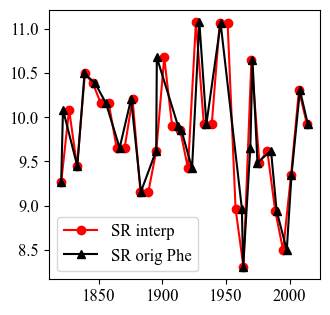

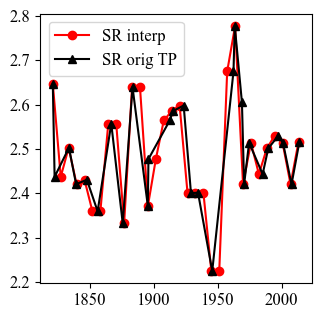

PI nointerp phe lag-1 ac 0.05471968784422516
PI interp phe lag-1 ac 0.09666332543488564
PI nointerp tp lag-1 ac 0.34027440862668684
PI interp tp lag-1 ac 0.3024519231978916


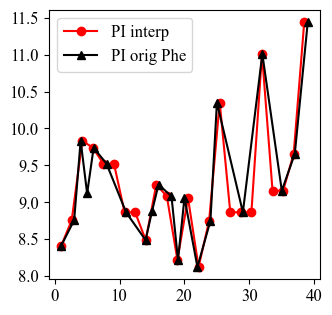

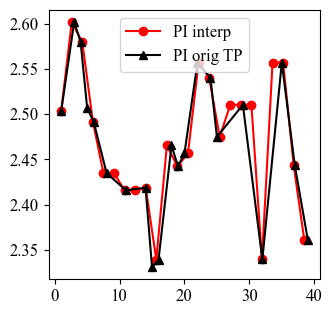

MC nointerp phe lag-1 ac 0.06631150152312244
MC interp phe lag-1 ac 0.14558956129161554
MC nointerp tp lag-1 ac -0.030015062058959742
MC interp tp lag-1 ac 0.058180088774036555


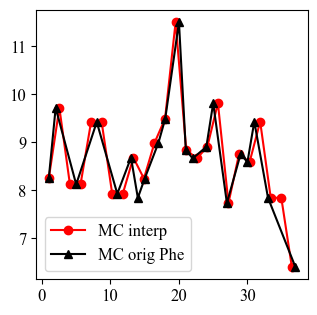

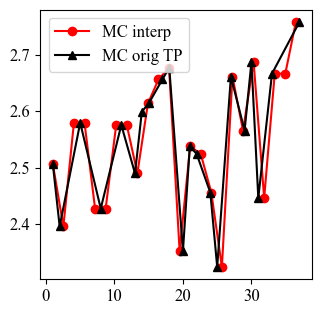

NPSG nointerp phe lag-1 ac 0.48598733318253773
NPSG interp phe lag-1 ac 0.5820257899729495
NPSG nointerp tp lag-1 ac -0.27996653239543834
NPSG interp tp lag-1 ac -0.03306043329246852


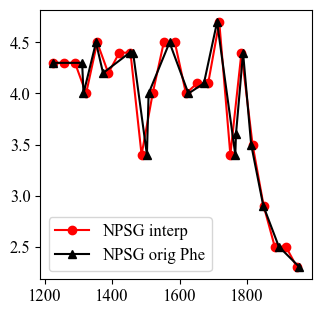

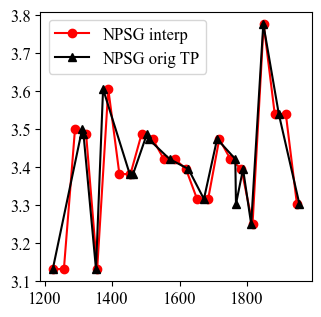

KR nointerp phe lag-1 ac 0.17283154121863814
KR interp phe lag-1 ac 0.22433183769020684
KR nointerp tp lag-1 ac 0.39591533733858125
KR interp tp lag-1 ac 0.435399872296272


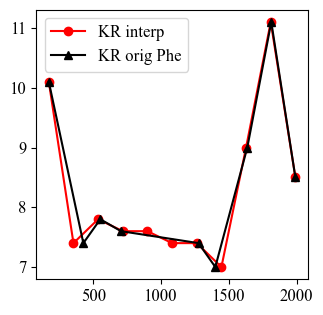

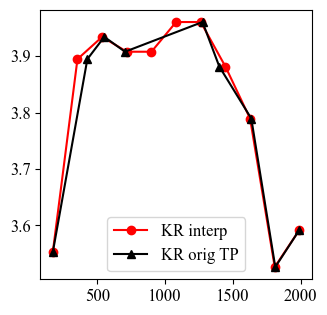

ET nointerp phe lag-1 ac 0.09702916347238451
ET interp phe lag-1 ac 0.19953295284734507
ET nointerp tp lag-1 ac -0.12691270872120505
ET interp tp lag-1 ac 0.031032217283632237


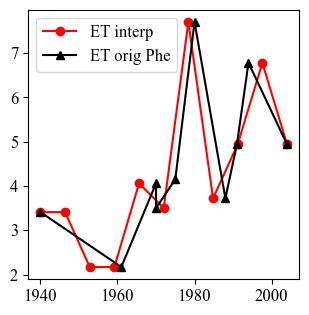

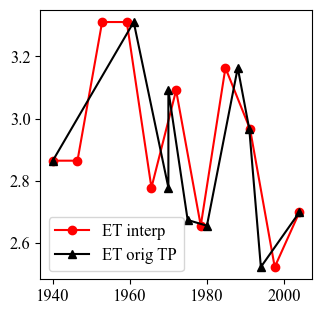

SWT nointerp phe lag-1 ac -0.3962902465322724
SWT interp phe lag-1 ac -0.352268541129977
SWT nointerp tp lag-1 ac -0.37108152060832506
SWT interp tp lag-1 ac -0.3347419256803719


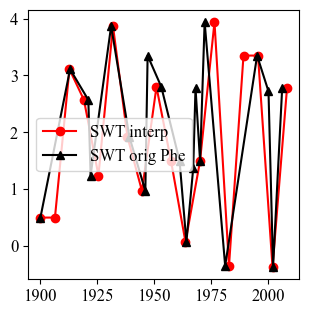

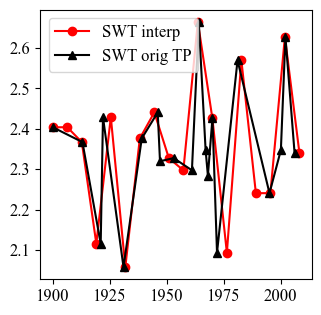

LHR nointerp phe lag-1 ac 0.33882074030285597
LHR interp phe lag-1 ac 0.37085268328667
LHR nointerp tp lag-1 ac 0.4001114642698721
LHR interp tp lag-1 ac 0.49247548292498144


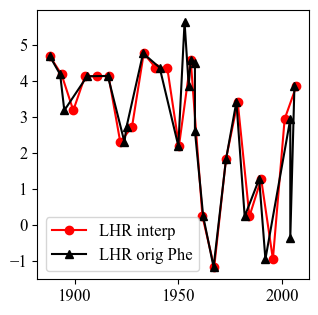

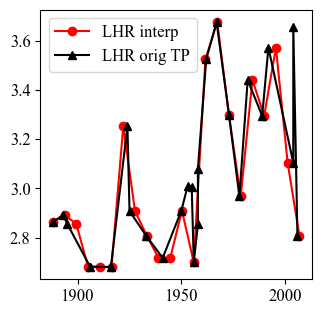

BS nointerp phe lag-1 ac 0.699371927519465
BS interp phe lag-1 ac 0.8009030979160956
BS nointerp tp lag-1 ac 0.3103720619693515
BS interp tp lag-1 ac 0.4774934271792198


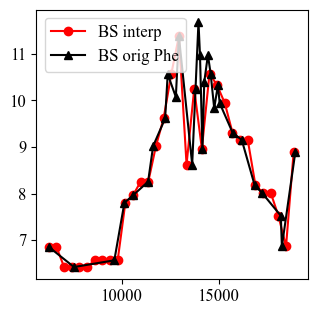

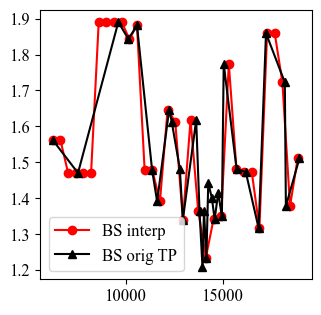

SBB nointerp phe lag-1 ac -0.018953068592057695
SBB interp phe lag-1 ac 0.17298507566147486
SBB nointerp tp lag-1 ac 0.17333333333333353
SBB interp tp lag-1 ac 0.21312260536398467


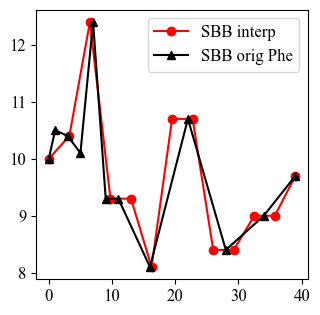

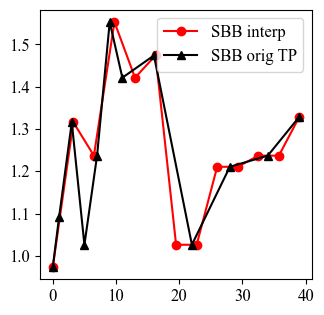

In [4]:
#Load Actual d15N datasets, process and summarize them

#names of dataset worksheets in .xlsx file
datasets=['Pugsley_SR','Shen_Pioneer','Shen_MontereyCanyon','Sherwood_gold','Glynn_equatorial',
          'Strzepek_ETas','Strzepek_SWTas','Strzepek_LHR','Delong_Bering','Batista_SBB']

# abbreviations to use for each study site
abbrev_list=['SR','PI','MC','NPSG','KR',
             'ET','SWT','LHR','BS','SBB']

# if dataset is a coral record, True
# if sediment record, False
coral_list=[True,True,True,True,True,
            True,True,True,False,False]

# latitude, longitude and depth for each study site
# for records with multiple coral collected close by, 
# the mean value is given
lat_list=[36.4, 37.359, 36.744, 21.29, 6.38, 
          -42.5, -45.3, -27.85, 53.4, 34.23]

lon_list=[-122.3,-123.394,-122.037,-157.54,-162.42,
          149.25,145.35,161.85,-179.52,-120.03]

depth_list=[1250, 1300, 870, 450, 400,
            1200, 2400, 1550, 1300, 450]

# step_mult values to input into
# lag1ac function. Smaller values mean
# a higher res interpolation.
# These have been tuned manually so the 
#interpolation matches features of 
# the original dataset well,
# to try to get a pretty accurate lag-1 
# autocorrelation value
step_mult_list=[.9,.9,.9,.9,.9,
                1,1.2,1.2,.9,1]

# create empty lists we will populate in a loop
age_obs_list=[]
Glu_obs_list=[]
Phe_obs_list=[]
Lys_obs_list=[]
TP_obs_list=[]
rho_obs_list=[]
slope_obs_list=[]

mean_list_phe=[]
mean_list_TP=[]
range_list_phe=[]
range_list_TP=[]
auto_list_phe=[]
auto_list_TP=[]
nobs_list=[]

# loop through each dataset in our compilation
for i in range(len(datasets)):

    #read in dataset from excel
    df_dataset=pd.read_excel(r'Datasets/TP_Phe comparison.xlsx',datasets[i])

    # drop one very low unrealistic TP value (<0.5) 
    # from Batista et al. Santa Barbara Basin dataset
    if abbrev_list[i]=='SBB':
        TP_check=TP(df_dataset['Glu'],df_dataset['Phe'],coral=coral_list[i])
        df_dataset=df_dataset.where(TP_check>0.9).dropna()

    #calculate TP
    TP_obs=TP(df_dataset['Glu'],df_dataset['Phe'],coral=coral_list[i])

    # for a few sites we don't have an age model
    # so am using sample id instead to determine lag-1 autocorrelation
    # assuming a constant growth or accumulation rate
    if datasets[i] in ['Shen_Pioneer','Shen_MontereyCanyon','Batista_SBB']:
        age_sel=df_dataset['Sample']
    else:
        age_sel=df_dataset['age']

    # create new dataframe with variables of interest from this specific dataset
    sorted_dataframe=pd.DataFrame({'age':age_sel,'Glu':df_dataset['Glu'],
                                   'Phe':df_dataset['Phe'],'Lys':df_dataset['Lys'],
                                   'TP':TP_obs}).sort_values(by='age')
    
    # append timeseries variables onto empty lists you made above
    age_obs_list.append(sorted_dataframe['age'])
    Glu_obs_list.append(sorted_dataframe['Glu'])
    Phe_obs_list.append(sorted_dataframe['Phe'])
    Lys_obs_list.append(sorted_dataframe['Lys'])
    TP_obs_list.append(sorted_dataframe['TP'])

    # calculate the lag-1 autocorrelation coefficient for TP and Phe
    auto_phe,phe_interp_time,phe_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['Phe'],step_mult=step_mult_list[i])
    auto_TP,TP_interp_time,TP_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['TP'],step_mult=step_mult_list[i])

    # print lag 1 ac for interpolated vs original timeseries to see what
    # the effect of interpolation is 
    print(abbrev_list[i]+' nointerp phe lag-1 ac',smt.acf(sorted_dataframe['Phe'],nlags=1,fft=True)[1])
    print(abbrev_list[i]+' interp phe lag-1 ac',auto_phe)
    print(abbrev_list[i]+' nointerp tp lag-1 ac',smt.acf(sorted_dataframe['TP'],nlags=1,fft=True)[1])
    print(abbrev_list[i]+' interp tp lag-1 ac',auto_TP)

    # plot the original vs interpolated time series to see how 
    # well the interpolation reproduces the main patterns in the 
    # data. Want to capture main features without adding too
    # many extra points, which artificially inflates the ac coefficient
    fig,ax=plt.subplots(figsize=(half_width,half_width))
    plt.plot(phe_interp_time,phe_interp,color='r',marker='o',label=abbrev_list[i]+' interp')
    plt.plot(sorted_dataframe['age'],sorted_dataframe['Phe'],color='k',marker='^',label=abbrev_list[i]+' orig Phe')
    plt.legend()
    plt.show()
    plt.close()
    
    fig,ax=plt.subplots(figsize=(half_width,half_width))
    plt.plot(TP_interp_time,TP_interp,color='r',marker='o',label=abbrev_list[i]+' interp')
    plt.plot(sorted_dataframe['age'],sorted_dataframe['TP'],color='k',marker='^',label=abbrev_list[i]+' orig TP')
    plt.legend()
    plt.show()
    plt.close()

    # calculate spearman's rho and the slope 
    # of the linear regression
    # between TP and Phe
    rho_obs=rho_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])
    m_obs=slope_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])

    # append stats of interest for each dataset into empty lists we made above
    rho_obs_list.append(np.round(rho_obs,2))
    slope_obs_list.append(np.round(m_obs,1))
    mean_list_phe.append(np.round(np.mean(sorted_dataframe['Phe']),1))
    mean_list_TP.append(np.round(np.mean(sorted_dataframe['TP']),1))
    range_list_phe.append(np.round(max(sorted_dataframe['Phe'])
                          -min(sorted_dataframe['Phe']),1))
    range_list_TP.append(np.round(max(sorted_dataframe['TP'])
                         -min(sorted_dataframe['TP']),1))
    auto_list_phe.append(np.round(auto_phe,2))
    auto_list_TP.append(np.round(auto_TP,2))
    nobs_list.append(len(sorted_dataframe['Phe']))

# create new summary dataframe from all the stats we calculated in the loop 
# above for each dataset
dataframe=pd.DataFrame({'Abbreviation': abbrev_list,
                        'Latitude':np.round(np.asarray(lat_list),1),
                        'Longitude':np.round(np.asarray(lon_list),1),
                        'Water Depth':depth_list,
                        'rho': np.round(np.asarray(rho_obs_list),2),
                        'slope': np.round(np.asarray(slope_obs_list),1),
                        'Phe mean':mean_list_phe,
                        'TP mean':mean_list_TP,
                        'Phe range':range_list_phe,
                        'TP range':range_list_TP,
                        'Phe Lag-1 AC':auto_list_phe,
                        'TP Lag-1 AC':auto_list_TP,
                        '# Obs':nobs_list
                       })

### View resulting summary dataframe and spearman correlations amongst variables

In [5]:
display(dataframe)
display(dataframe.corr(method='spearman',numeric_only=True))

,Abbreviation,Latitude,Longitude,Water Depth,rho,slope,Phe mean,TP mean,Phe range,TP range,Phe Lag-1 AC,TP Lag-1 AC,# Obs
0,SR,36.4,-122.3,1250,-0.71,-4.4,9.8,2.5,2.8,0.6,0.14,0.16,28
1,PI,37.4,-123.4,1300,-0.23,-4.1,9.3,2.5,3.3,0.3,0.10,0.30,21
2,MC,36.7,-122.0,870,-0.68,-6.5,8.7,2.5,5.1,0.4,0.15,0.06,21
3,NPSG,21.3,-157.5,450,-0.22,-1.1,3.9,3.4,2.4,0.6,0.58,-0.03,20
4,KR,6.4,-162.4,400,-0.73,-6.9,8.4,3.8,4.1,0.4,0.22,0.44,9
5,ET,-42.5,149.2,1200,-0.80,-4.9,4.5,2.9,5.5,0.8,0.20,0.03,10
6,SWT,-45.3,145.4,2400,-0.85,-7.3,2.0,2.4,4.3,0.6,-0.35,-0.33,20
7,LHR,-27.8,161.8,1550,-0.80,-5.6,2.8,3.1,6.8,1.0,0.37,0.49,25
8,BS,53.4,-179.5,1300,-0.52,-3.8,9.1,1.5,5.3,0.7,0.80,0.48,29
9,SBB,34.2,-120.0,450,-0.44,-2.6,9.8,1.2,4.3,0.6,0.17,0.21,12


,Latitude,Longitude,Water Depth,rho,slope,Phe mean,TP mean,Phe range,TP range,Phe Lag-1 AC,TP Lag-1 AC,# Obs
Latitude,1.000000,-0.636364,-0.091465,0.717329,0.503030,0.741645,-0.374261,-0.218846,-0.388946,0.103030,0.393939,0.585377
Longitude,-0.636364,1.000000,0.378056,-0.595747,-0.345455,-0.370822,-0.055219,0.534957,0.464226,-0.333333,-0.212121,-0.146344
Water Depth,-0.091465,0.378056,1.000000,-0.422020,-0.262200,-0.302754,-0.345686,0.370032,0.353455,-0.298786,0.079270,0.588957
rho,0.717329,-0.595747,-0.422020,1.000000,0.826752,0.536585,-0.123082,-0.542683,-0.415300,0.224925,0.072949,0.152906
slope,0.503030,-0.345455,-0.262200,0.826752,1.000000,0.474166,-0.214740,-0.322190,0.112920,0.406061,0.078788,0.207321
Phe mean,0.741645,-0.370822,-0.302754,0.536585,0.474166,1.000000,-0.461558,-0.301829,-0.358668,-0.164134,0.291795,0.238533
TP mean,-0.374261,-0.055219,-0.345686,-0.123082,-0.214740,-0.461558,1.000000,-0.153853,-0.025403,0.337449,0.042948,-0.339513
Phe range,-0.218846,0.534957,0.370032,-0.542683,-0.322190,-0.301829,-0.153853,1.000000,0.629242,0.261399,0.340427,0.100918
TP range,-0.388946,0.464226,0.353455,-0.415300,0.112920,-0.358668,-0.025403,0.629242,1.000000,0.501866,0.131740,0.205130
Phe Lag-1 AC,0.103030,-0.333333,-0.298786,0.224925,0.406061,-0.164134,0.337449,0.261399,0.501866,1.000000,0.430303,0.079270


### Fig. 2a load Rafter 2019 d15N ANN output into pandas dataframes and plot with site locations

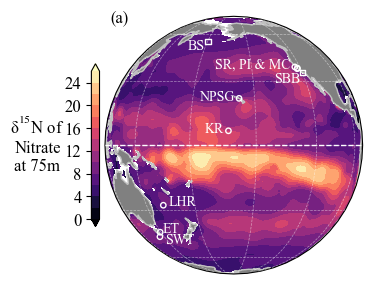

In [6]:
# load Rafter 2019 d15N ANN output into pandas dataframes and plot with site locations

#load Rafter et al., 2019 dataset into pandas dataframe
d15N_df=pd.read_csv(r'Datasets/dataset-768655_global-model-nitrate-d15n__v1.csv',
                 header=0)

#assign coordinates to indices in pandas 
d15N_df = d15N_df.set_index(['latitude', 'longitude','depth'])

# convert d15N pandas dataframe to xarray DataArray
d15N=d15N_df.to_xarray()
d15N=d15N.d15N

#select depth of interest (if choosing depth already in data)
depth=75
d15N_depth_sel=d15N.sel(depth=depth,method='nearest')

#uncomment this code segment below if want to interpolate to different depth:
# #--------------------------------------------------------------------------
# # to interpolate to any depth of choice, must convert dataset to xgcm Grid
# # and use xgcm Grid.transform to interpolate 
# depth=85 #set depth of interest
# # convert xarray dataset to xgcm Grid
# grid = Grid(d15N.to_dataset(), 
#             coords={'X': {'center':'longitude'},
#                     'Y': {'center':'latitude'},
#                     'Z': {'center': 'depth'}},
#             periodic=False)
# # create array with target depth
# target_depth_level = np.asarray([depth])
# # interpolate dataset to target depth
# d15N = grid.transform(d15N.to_dataset().d15N, 'Z', 
#                       target_depth_level, target_data=None, 
#                       method='linear')
# # convert from 3d to 2d for easier plotting by selecting only
# # depth of interest
# d15N_depthsel=d15N.sel(depth=depth)
# #--------------------------------------------------------------------------

#make map of sites with modern d15N NO3 from Rafter et al., 2019 

#create list of sampling sites labels from compiled observations
lats_obs=dataframe.Latitude
lons_obs=dataframe.Longitude

#set lat and lon coordinates where you want center of map to be
central_lon,central_lat=-160,0

# initialize plot
fig = plt.figure(figsize=(half_width,half_width))

#select map projection
proj='ortho'

#initialize subplot with chosen map projection
if proj== 'mollweide':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Mollweide(central_longitude=central_lon))
    fraction=0.015
elif proj == 'robinson':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson(central_longitude=central_lon))
    fraction=0.015
elif proj in ['ortho','orthographic']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.Orthographic(central_lon,central_lat))
    fraction=0.03
elif proj in ['pc','PlateCarree']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree(central_longitude=central_lon))
    fraction=0.03
else:
    print("please select one of 'mollweide', 'robinson','pc' or 'ortho'")

#plot deep-sea coral study sites locations
plt.scatter(lons_obs.where(pd.DataFrame(coral_list)[0]==True),
            lats_obs.where(pd.DataFrame(coral_list)[0]==True),
            s=15,color='None',ec='w',
           linestyle='None',marker='o',
           transform=crs.PlateCarree(),zorder=10)
#plot sediment core study site locations
plt.scatter(lons_obs.where(pd.DataFrame(coral_list)[0]==False),
            lats_obs.where(pd.DataFrame(coral_list)[0]==False),
            s=15,color='None',ec='w',
           linestyle='None',marker='s',
           transform=crs.PlateCarree(),zorder=10)

# specify labels to add to each study site 
abbrev=['','','SR, PI & MC','NPSG','KR',
        'ET','SWT','LHR','BS','SBB']

#customize placement of each label
lons_shift=[0, 0, -4, -2, -2,
            4,  3, 4, -1, -3]
lats_shift=[0, 0,  2,  1,  1,
            2, -2, 2, -3, -3]
ha=['left','left','right','right','right',
    'left','left','left','right','right']
for i in np.arange(0,len(abbrev)):
    ax.text(lons_obs[i]+lons_shift[i],
            lats_obs[i]+lats_shift[i],
            abbrev[i], 
            ha=ha[i],va='center',
            fontsize=10,rotation=0,
            color='w',transform=crs.PlateCarree())

# make filled contour plot of the Rafter et al 2019 
# nitrate d15N climatology at selected depth level
contour=ax.contourf(d15N.longitude, d15N.latitude, d15N_depth_sel,
                    levels=np.arange(0,26.1,2),extend='both',
                    cmap='magma',transform=crs.PlateCarree())

#add and configure colorbar settings
cbar=fig.colorbar(contour, orientation='vertical',
                  fraction=fraction, pad=0.02,location='left')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\mathdefault{δ^{15}N}$ of\nNitrate\nat '+str(depth)+'m',
               rotation=0,va='center',labelpad=20,fontsize=12)

# add land masses to map
ax.add_feature(NaturalEarthFeature('physical', 'land', '110m'),
               edgecolor='silver',lw=1,facecolor='grey',alpha=1,zorder=1)

#configure gridlines
gl=ax.gridlines(draw_labels=False, crs=crs.PlateCarree(),
             linewidth=.5, color='w', alpha=0.5, linestyle='--',zorder=5)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-60,61,30))
gl2=ax.gridlines(draw_labels=False, ylocs=[0],  #special bold gridline for equator
             linewidth=1, color='w', alpha=1, linestyle='--',zorder=5)
gl2.xlines=False

#if projection is PlateCarree, set axis limits
# otherwise get to global coverage
if proj in ['pc','PlateCarree']:
    ax.set_extent([-240, -100, -65, 65],crs=crs.PlateCarree())
else:
    ax.set_global()

# add subplot label
ax.text(0.02,0.98,'(a)',transform=ax.transAxes)

plt.savefig('Figures/Fig2a.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2a.pdf',bbox_inches='tight', dpi=1000)
plt.show()

### Extract Mean d15N NO3 @ depth selected above at each study site from Rafter et al 2019 neural network climatology dataset

In [7]:
# copy the nitrate d15N climatology xarray Dataset
# and convert latitude from 0-360 to -180 to 180
# so it matches the paleo dataset coordinates
d15N_newlon=d15N
d15N_newlon.coords['longitude'] = (d15N.coords['longitude'] + 180) % 360 - 180
d15N_newlon = d15N_newlon.sortby(d15N.longitude)

# select depth of interest
d15N_depth_sel=d15N_newlon.sel(depth=depth)

# interpolate nitrate d15N climatology dataset to nearest longitude
# in order to fill nan values 
# (was a problem at a few sites very close to land) 
d15N_sel=d15N_depth_sel.interpolate_na(dim='longitude',method='nearest')

# create empty list to populate 
# with d15N NO3 values from each site 
d15N_NO3_list=[]

# loop through each study site,
# find d15N NO3 value at chosen depth
# that's closest to sampling location
for i in dataframe.index:
    d15N_point=d15N_sel.sel(latitude=dataframe['Latitude'].iloc[i],
                            longitude=dataframe['Longitude'].iloc[i],
                            method='nearest')
    d15N_NO3_list.append(np.round(d15N_point.values,2))

# add d15N NO3 values for each study site 
# to the summary dataframe and display the values
dataframe['d15N NO3']=d15N_NO3_list
display(dataframe.loc[:,['Abbreviation','Latitude',
                         'Longitude','d15N NO3']])

,Abbreviation,Latitude,Longitude,d15N NO3
0,SR,36.4,-122.3,9.23
1,PI,37.4,-123.4,9.44
2,MC,36.7,-122.0,9.23
3,NPSG,21.3,-157.5,7.52
4,KR,6.4,-162.4,13.61
5,ET,-42.5,149.2,6.82
6,SWT,-45.3,145.4,8.03
7,LHR,-27.8,161.8,7.35
8,BS,53.4,-179.5,6.52
9,SBB,34.2,-120.0,7.94


### Figure 2b plot TP vs Phe corrected to site-specific d15N NO3 value

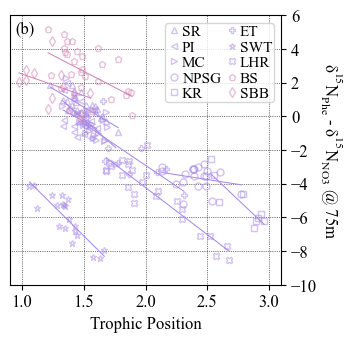

In [8]:
# set markers to used for each study site
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']

# set colors to use
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor #select color
        
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1 
    else:
        mec_sel=sedcolor #select color
        
        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
        
    # subtract d15N NO3 at given site and selected depth from 
    # Rafter et al., 2019 climatology
    Phe_calc=Phe_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    
    # plot TP vs Phe points
    plt.plot(TP_sel,
             Phe_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Phe_calc)[0]
    b=scipy.stats.linregress(TP_sel,Phe_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,linestyle='-',alpha=1,
             lw=.75,color=mec_sel)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
             rotation=270,labelpad=20)

#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-10,6)

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add legend
ax.legend(fontsize=11,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig2b.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2b.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


### Supplementary figure TP vs Lys

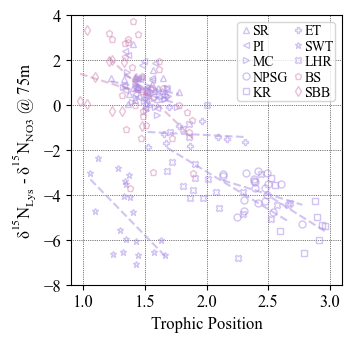

In [9]:
# TP vs Lys corrected for Lys trophic fractionation
Lys_TDF=1

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

# loop through the compiled paleo datasets
# plotting TP vs d15N Lys normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor  #select color
        
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1
        
        # subtract d15N NO3 at given site and selected depth from 
        # Rafter et al., 2019 climatology 
        # and correct for trophic Lys fractionation
        # for coral TP correction use original TP bc need to correct
        # for Lys fractionation between coral and diet
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]-((TP_obs_list[i]-1)*Lys_TDF)
        
    else:
        mec_sel=sedcolor

        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
        
        # subtract d15N NO3 at given site and selected depth from 
        # Rafter et al., 2019 climatology 
        # and correct for trophic Lys fractionation
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]-((TP_sel-1)*Lys_TDF)

    # plot TP vs corrected Lys points
    plt.plot(TP_sel,
             Lys_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Lys_calc)[0]
    b=scipy.stats.linregress(TP_sel,Lys_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,
             linestyle='--',
             alpha=.5,
             color=mec_sel)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Lys}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m')

#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-8,4)

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

#add legend
ax.legend(fontsize=10,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

# save figure, display and close
plt.savefig('Figures/Supplemental_TPvLys_corr.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


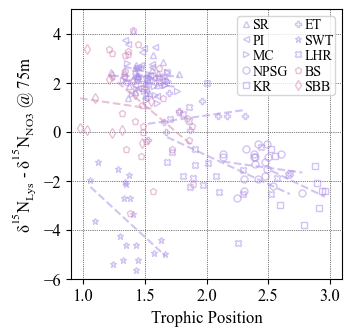

In [10]:
# TP vs Lys (not corrected for Lys trophic fractionation)

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,half_width))

# loop through the compiled paleo datasets
# plotting TP vs d15N Lys normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor #select marker color

        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1

        # subtract d15N NO3 at given site and selected depth from 
        # Rafter et al., 2019 climatology 
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]
        
    else:
        mec_sel=sedcolor #select marker color

        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]

    # plot TP vs corrected Lys points
    plt.plot(TP_sel,
             Lys_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Lys_calc)[0]
    b=scipy.stats.linregress(TP_sel,Lys_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,
             linestyle='--',
             alpha=.5,
             color=mec_sel)

#set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Lys}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m')

#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-6,5)

#add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

#add legend
ax.legend(fontsize=10,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))


plt.savefig('Figures/Supplemental_TPvLys_uncorr.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


# -----------------------------------------------------------------------------------------
# Spurious Correlations Analysis

#### Could the  relationships we see in the paleoceanographic datasets be a statistical artifact?

### Set default parameters for simulations, unless changed for sensitivity analyses

In [81]:
# default parameters

# length of simulated timeseries
n_def=int(np.round(np.mean(dataframe['# Obs'])))

# number of simulated timeseries
nsims_def=10000  

# calculate correlations with spearman or pearson?
corrtest_def='spearman'        

# distribution for simulating uncertainties
uncertainty_dist_def='normal'   

# ranges for TP and baseline timeseries
TP_range_def=[2.2,2.2+np.mean(dataframe['TP range'])]          
baseline_range_def=[-np.mean(dataframe['Phe range'])/2,
                    np.mean(dataframe['Phe range'])/2]    

# TDF values and uncertainties for Glu and Phe
# TDF values from Chikaraishi et al., 2009
Phe_TDF_def=0.4
Glu_TDF_def=8.0
Phe_TDF_std_def=0 #Chikaraishi value=0.5
Glu_TDF_std_def=0 #Chikaraishi value=1.2

# lag-1 autocorrelation coefficients
# for simulated TP and Phe timeseries
lag1ac_TP_def=np.mean(dataframe['TP Lag-1 AC'])
lag1ac_baseline_def=np.mean(dataframe['Phe Lag-1 AC'])

# Uncertainty from repeated triplicate measurements
# of long-term McCarthy lab cyanobacteria standard 
# over 5 years (Christensen et al., 2023)
Glu_meas_std_def=0.7  # Christensen et al.,2023 value=0.6
Phe_meas_std_def=0.7
                            
# nonvascular autotroph beta and uncertainty
# from Ramirez et al. 2021
beta_def=3.4
beta_std_def=0 #Ramirez et al. 2021 value=1.8

# correction for polyp-skeleton offset, 
# in Coral TP estimation
# from McMahon et al. 2018
d_def=3.4
d_std_def=0 #McMahon et al 2018 value=0.1   

# should d15N baseline vary through time?
baseline_variability_def=True

# is the simualtion for a coral?
# if so will account for d uncertainty
# and calculate TP using coral-specific equation
coral_def=True

### Simulate n=10,000 TP and Phe timeseries, starting with a realistic but fairly conservative simulation (defaults)

In [106]:
# realistic scenario
from matplotlib import colors
"""
Simulate n=10,000 measured TP and Phe time series
"""
Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Phe_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)

#find the pearson correlation and original unadjusted p-value for the 
# Sur Ridge Coral Data

# uncomment code snippet below if want to calculate p-value for 
# a slope or correlation coefficient based on probability distribution 
# from simulations above
#------------------------------------------------------------------------
#Alternate correlation p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(rho_sims, rho_actual)/100

#Alternate slope p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(slope_sims, slope_actual)/100
#------------------------------------------------------------------------

"""
Find critical rho and slope values from 
probability distribution of simulations
"""
#find critical rho value based on simulations
crit_rho_onetail=scipy.stats.scoreatpercentile(rho_sims, 5)
crit_rho_twotail_lower=scipy.stats.scoreatpercentile(rho_sims, 2.5)
crit_rho_twotail_upper=scipy.stats.scoreatpercentile(rho_sims, 97.5)
median_rho=scipy.stats.scoreatpercentile(rho_sims, 50)

#find critical slope value based on simulations
crit_slope_onetail=scipy.stats.scoreatpercentile(slope_sims, 5)
crit_slope_twotail_lower=scipy.stats.scoreatpercentile(slope_sims, 2.5)
crit_slope_twotail_upper=scipy.stats.scoreatpercentile(slope_sims, 97.5)
median_slope=scipy.stats.scoreatpercentile(slope_sims, 50)

### Figure 3. View simulation results and plot figures 

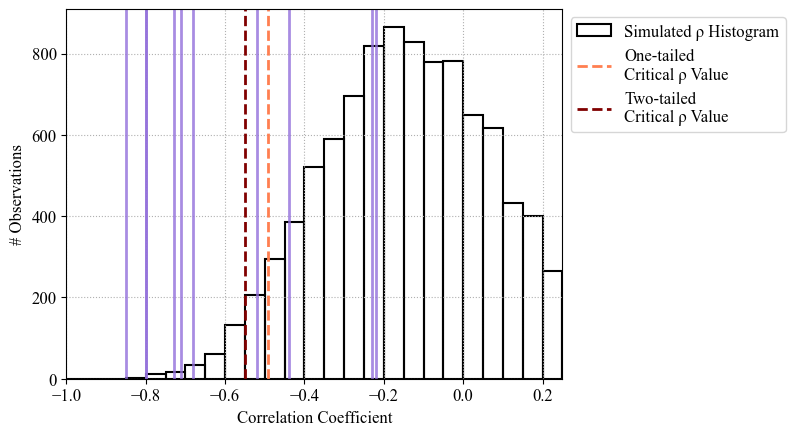

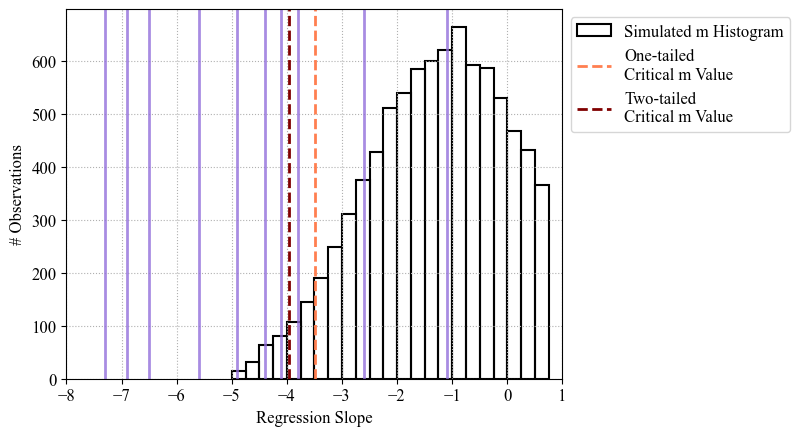

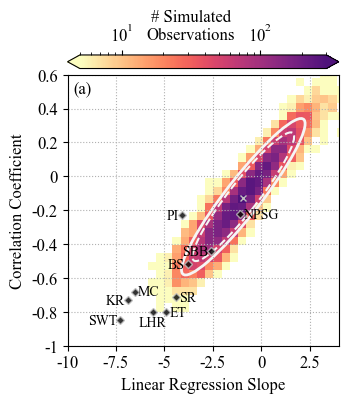

In [117]:
"""
Plot histogram of spearman's rho from simulations
with observed rho values from paleo datasets
"""
fig,ax=plt.subplots()
bin_edges=np.arange(-1,1,0.05)
ax.grid(linestyle=':',zorder=-20)
ax.hist(rho_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated ρ Histogram')
for i in dataframe['rho']:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_rho_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Correlation Coefficient')
plt.ylabel('# Observations')
ax.set_xlim(-1,.25)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

"""
Plot histogram of regression slopes from simulations
with observed slope values from paleo datasets
"""
fig,ax=plt.subplots()
bin_edges=np.arange(-5,1,0.25)
ax.grid(linestyle=':',zorder=-20)
ax.hist(slope_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated m Histogram')
for i in dataframe['slope']:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_slope_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Regression Slope')
plt.ylabel('# Observations')
ax.set_xlim(-8,1)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

"""
Plot 2d histogram of regression slopes and rho values
from simulations with observed values from paleo datasets
"""
# select colormap
cmap_orig = matplotlib.colormaps['magma_r']
cmap = ListedColormap(cmap_orig(np.linspace(0, 0.75, 200)))

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,4))

# plot 2d histogram of simulated slope and rho values
counts,ybins,xbins,im=ax.hist2d(slope_sims, rho_sims, bins=30, density=False,
                                norm=colors.LogNorm(vmin=5,vmax=300), 
                                cmin=2,cmap=cmap,zorder=1)

#add x denoting median simulation values
ax.plot(median_slope,median_rho,marker='x',
        color='silver',markersize=4,linestyle='None')

#add colorbar
cb=plt.colorbar(im,extend='both',location='top',
                fraction=.1,pad=0.02)
cb.set_label('# Simulated\nObservations', labelpad=-12,
             fontsize=12,x=.45)

# plot rho and slope values from real coral and sediment datasets
for i in np.arange(0,len(dataframe.index),1):
    if i == 0:
        ax.plot(dataframe['slope'][i],dataframe['rho'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None',
                label='Observations')
    else:
        ax.plot(dataframe['slope'][i],dataframe['rho'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None')
    #add labels with each dataset abbreviation
    if dataframe['Abbreviation'][i] in ['SR','MC','NPSG','ET']:
        ax.text(dataframe['slope'][i]+.15,dataframe['rho'][i], 
                dataframe['Abbreviation'][i], ha='left',
                va='center',fontsize=10,rotation=0,color='k')
    elif dataframe['Abbreviation'][i] in ['LHR']:
        ax.text(dataframe['slope'][i],dataframe['rho'][i]-.02, 
                dataframe['Abbreviation'][i], ha='center',
                va='top',fontsize=10,rotation=0,color='k')
    else:
        ax.text(dataframe['slope'][i]-.15,dataframe['rho'][i], 
                dataframe['Abbreviation'][i], ha='right',
                va='center',fontsize=10,rotation=0,color='k')  

# add 90% and 95% confidence ellipses
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=1.645,
                   edgecolor='whitesmoke',linestyle='--',lw=1.5,label='90% CI')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=2.0,
                   edgecolor='whitesmoke',linestyle='-',lw=2,label='95% CI')

# set axis labels
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',fontsize=12)

#set axis limits
ax.set_ylim(-1,.6)
ax.set_xlim(-10,4)

# misc axis formatting
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.5))

#add gridlines
ax.grid(linestyle=':',zorder=10)

# add subplot label
text=ax.text(0.02,0.98,'(a)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#add legend
#plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=10)

#save figure, display and close
plt.savefig('Figures/Fig3.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig3.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Plot monte Carlo Simulation Results with compilation results

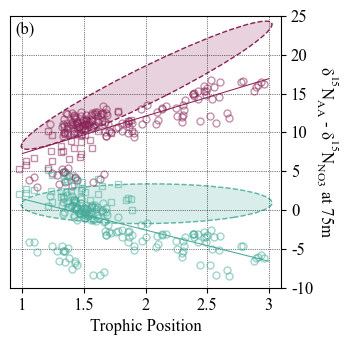

In [121]:
#Run monte carlo simulation (just one simulated dataset with n=10,000
Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=10000,
                                                                       nsims=1,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=[2,4],
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Phe_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=True)

# set colors to use
phe_color='#44AA99'
glu_color='#882255'

#set markers
sedmarker='s'#'#CC7AA0'#
coralmarker='o'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,3.53))

# plot TP vs Phe Confidence ellipse 
# from Monte Carlo simulations

confidence_ellipse(np.asarray(TP_sims).flatten()-1, 
                   np.asarray(Phe_sims).flatten(), 
                   ax, n_std=2.0,facecolor=phe_color,
                   edgecolor=phe_color,alpha=.2,
                   linestyle='--',
                   lw=1,label='95% CI',zorder=-10)
confidence_ellipse(np.asarray(TP_sims).flatten()-1, 
                   np.asarray(Phe_sims).flatten(), 
                   ax, n_std=2.0,
                   edgecolor=phe_color,alpha=.8,
                   linestyle='--',
                   lw=1,label='95% CI',zorder=-10)

# plot TP vs Glu from Monte Carlo simulations

confidence_ellipse(np.asarray(TP_sims).flatten()-1, 
                   np.asarray(Glu_sims).flatten(), 
                   ax, n_std=2.0,facecolor=glu_color,
                   edgecolor=glu_color,alpha=.2,
                   linestyle='None',
                   lw=0,zorder=-10)
confidence_ellipse(np.asarray(TP_sims).flatten()-1, 
                   np.asarray(Glu_sims).flatten(), 
                   ax, n_std=2.0,
                   edgecolor=glu_color,alpha=1,
                   linestyle='--',
                   lw=1,label='95% CI',zorder=-10)

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe and d15N Glu
# normalized to d15N NO3 from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 

# first create flat lists we will append the selected
# data to for regression analysis later
adj_TP_list=[]
adj_Phe_list=[]
adj_Glu_list=[]

for i in dataframe.index:
    if coral_list[i]==True:
        m_sel=coralmarker #select color
        
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1 
    else:
        m_sel= sedmarker
        
        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
    
    # subtract d15N NO3 at given site and selected depth from 
    # Rafter et al., 2019 climatology
    Phe_calc=Phe_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    Glu_calc=Glu_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    
    # plot TP vs Phe points
    ax.plot(TP_sel,
             Phe_calc,
             linestyle='None',color='None',
             mec=phe_color,alpha=.5,ms=5,
             marker=m_sel,
             label=dataframe['Abbreviation'].iloc[i])

    # plot TP vs Glu points
    #ax2=ax.twinx()
    ax.plot(TP_sel,
             Glu_calc,
             linestyle='None',color='None',
             mec=glu_color,alpha=.5,ms=5,
             marker=m_sel,
             label=dataframe['Abbreviation'].iloc[i])

    #add selected data to flat list for regression
    adj_TP_list.extend(TP_sel)
    adj_Phe_list.extend(Phe_calc)
    adj_Glu_list.extend(Glu_calc)

# calculate slope and intercept for the TP-Phe
# regression across all paleo datasets and plot
m=scipy.stats.linregress(adj_TP_list,adj_Phe_list)[0]
b=scipy.stats.linregress(adj_TP_list,adj_Phe_list)[1]
x=np.asarray([1,3])
plt.plot(x,m*x+b,linestyle='-',alpha=1,
         lw=.75,color=phe_color)

# # calculate slope and intercept for the TP-Glu
# # regression in each dataset and plot
m=scipy.stats.linregress(adj_TP_list,adj_Glu_list)[0]
b=scipy.stats.linregress(adj_TP_list,adj_Glu_list)[1]
x=np.asarray([1,3])
plt.plot(x,m*x+b,linestyle='-',alpha=1,
         lw=.75,color=glu_color)


# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{AA}}$ - $\mathdefault{δ^{15}N_{NO3}}$ at 75m',
             rotation=270,labelpad=20)
# ax2.set_ylabel('$\mathdefault{δ^{15}N_{Glu}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
#              rotation=270,labelpad=20)
#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-10,25)

#set axis label format
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig3b.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Sensitivity analyses (realistic scenario)

In [14]:
#Sensitivity analyses (realistic scenario)
nsims_def_sens=1000

#sensitivity to measurement error
i_list_meas=[]
median_list_meas=[]
onetail_list_meas=[]
median_slopelist_meas=[]
onetail_slopelist_meas=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=i,
                                                                       Phe_meas_std=i,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_meas.append(i)
    median_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Measurement error ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to persistence
i_list_auto=[]
median_list_auto=[]
onetail_list_auto=[]
median_slopelist_auto=[]
onetail_slopelist_auto=[]
low,high=0,.98
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=i,
                                                                       lag1ac_baseline=i,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_auto.append(i)
    median_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Persistence ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to baseline range variability, autocorrelation held constant
i_list_baserange=[]
median_list_baserange=[]
onetail_list_baserange=[]
median_slopelist_baserange=[]
onetail_slopelist_baserange=[]
low,high=0,7
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=[0,i],
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_baserange.append(i)
    median_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Baseline range ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to TP range variability, autocorrelation held constant
i_list_TPrange=[]
median_list_TPrange=[]
onetail_list_TPrange=[]
median_slopelist_TPrange=[]
onetail_slopelist_TPrange=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=[2.1,2.1+i],
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_TPrange.append(i)
    median_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('TP range ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to sample size
i_list_nobs=[]
median_list_nobs=[]
onetail_list_nobs=[]
median_slopelist_nobs=[]
onetail_slopelist_nobs=[]
low,high=4,100
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=int(i),
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_nobs.append(i)
    median_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Sample size ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to Glu TDF uncertainty
i_list_glutdf=[]
median_list_glutdf=[]
onetail_list_glutdf=[]
median_slopelist_glutdf=[]
onetail_slopelist_glutdf=[]
low,high=0,4
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=i,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_glutdf.append(i)
    median_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Glu TDF uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to Beta uncertainty
i_list_beta=[]
median_list_beta=[]
onetail_list_beta=[]
median_slopelist_beta=[]
onetail_slopelist_beta=[]
low,high=0,3
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=i,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_beta.append(i)
    median_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Beta uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to d uncertainty
i_list_d=[]
median_list_d=[]
onetail_list_d=[]
median_slopelist_d=[]
onetail_slopelist_d=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=i,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_d.append(i)
    median_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('d uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1

print ('finished :)')

Measurement error  1  out of  13
Measurement error  2  out of  13
Measurement error  3  out of  13
Measurement error  4  out of  13
Measurement error  5  out of  13
Measurement error  6  out of  13
Measurement error  7  out of  13
Measurement error  8  out of  13
Measurement error  9  out of  13
Measurement error  10  out of  13
Measurement error  11  out of  13
Measurement error  12  out of  13
Measurement error  13  out of  13
Persistence  1  out of  13
Persistence  2  out of  13
Persistence  3  out of  13
Persistence  4  out of  13
Persistence  5  out of  13
Persistence  6  out of  13
Persistence  7  out of  13
Persistence  8  out of  13
Persistence  9  out of  13
Persistence  10  out of  13
Persistence  11  out of  13
Persistence  12  out of  13
Persistence  13  out of  13
Baseline range  1  out of  13
Baseline range  2  out of  13
Baseline range  3  out of  13
Baseline range  4  out of  13
Baseline range  5  out of  13
Baseline range  6  out of  13
Baseline range  7  out of  13
Ba

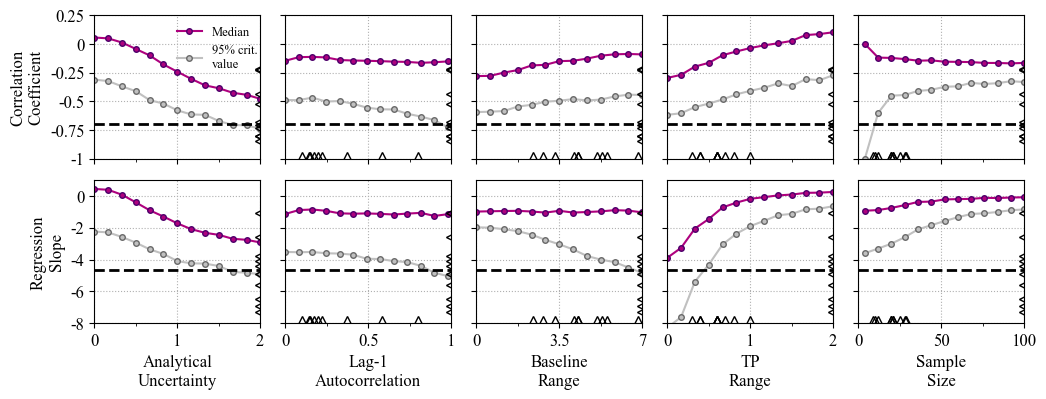

In [15]:
# plotting sensitivity analyses 

# i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_glutdf,i_list_beta,i_list_d]
# median_lists=[median_list_meas,median_list_auto,median_list_baserange,median_list_glutdf,median_list_beta,median_list_d]
# onetail_lists=[onetail_list_meas,onetail_list_auto,onetail_list_baserange,onetail_list_glutdf,onetail_list_beta,onetail_list_d]
# var_list=['Analytical\nUncertainty','Autocorrelation','Baseline\nRange','TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

# actual_rho=scipy.stats.pearsonr(TP_actual,Phe_actual)[0]

# cols=len(i_lists)

# fig,axs=plt.subplots(nrows=1,ncols=cols,figsize=(12,2),sharey='all')
# fig.subplots_adjust(wspace=0.15)
# for i in np.arange(0,cols,1):
#     axs[i].plot(i_lists[i],median_lists[i],color='k',marker='o',markersize=4,label='Median')
#     axs[i].plot(i_lists[i],onetail_lists[i],color='r',marker='o',markersize=4,label='95% critical\nvalue')
#     axs[i].axhline(actual_rho,color='k',linestyle='--')
#     axs[i].grid(linestyle=':',zorder=-20)
#     axs[i].set_xlabel(var_list[i],fontsize=12)
#     axs[i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
#     axs[i].set_ylim(-1,0.25)
#     axs[i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
#     axs[i].yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
# axs[0].set_ylabel('Correlation\nCoefficient')
# plt.legend(fontsize=10,frameon=False)
# plt.show()
# plt.close()

# #regression slope
# from matplotlib.ticker import FormatStrFormatter
# import matplotlib.ticker as ticker

# i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_glutdf,i_list_beta,i_list_d]
# median_lists=[median_slopelist_meas,median_slopelist_auto,median_slopelist_baserange,median_slopelist_glutdf,median_slopelist_beta,median_slopelist_d]
# onetail_lists=[onetail_slopelist_meas,onetail_slopelist_auto,onetail_slopelist_baserange,onetail_slopelist_glutdf,onetail_slopelist_beta,onetail_slopelist_d]
# var_list=['Analytical\nUncertainty','Autocorrelation','Baseline\nRange','TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

# actual_slope=scipy.stats.linregress(TP_actual,Phe_actual)[0]

# cols=len(i_lists)

# fig,axs=plt.subplots(nrows=1,ncols=cols,figsize=(12,2),sharey='all')
# fig.subplots_adjust(wspace=0.15)
# for i in np.arange(0,cols,1):
#     axs[i].plot(i_lists[i],median_lists[i],color='k',marker='o',markersize=4,label='Median')
#     axs[i].plot(i_lists[i],onetail_lists[i],color='r',marker='o',markersize=4,label='95% critical\nvalue')
#     axs[i].axhline(actual_slope,color='k',linestyle='--')
#     axs[i].grid(linestyle=':',zorder=-20)
#     axs[i].set_xlabel(var_list[i],fontsize=12)
#     axs[i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
#     axs[i].set_ylim(-5,1)
#     axs[i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
#     axs[i].yaxis.set_major_locator(ticker.MultipleLocator(base=1))
# axs[0].set_ylabel('Regression\nSlope')
# plt.legend(fontsize=10,frameon=False)
# plt.show()
# plt.close()

# plotting sensitivity analyses both together

#correlation
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_TPrange,i_list_nobs]#i_list_glutdf,i_list_beta,i_list_d]
median_lists=[median_list_meas,median_list_auto,median_list_baserange,median_list_TPrange,median_list_nobs]#median_list_glutdf,median_list_beta,median_list_d]
onetail_lists=[onetail_list_meas,onetail_list_auto,onetail_list_baserange,onetail_list_TPrange,onetail_list_nobs]#onetail_list_glutdf,onetail_list_beta,onetail_list_d]
var_list=['Analytical\nUncertainty','Lag-1\nAutocorrelation','Baseline\nRange','TP\nRange','Sample\nSize']#'TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

cols=len(i_lists)

fig,axs=plt.subplots(nrows=2,ncols=cols,figsize=(12,4),sharey='row',sharex='col')
fig.subplots_adjust(wspace=0.15,hspace=0.15)
for i in np.arange(0,cols,1):
    axs[0,i].plot(i_lists[i],median_lists[i],color='#ae017e',marker='o',markersize=4,mec='#4c006b',label='Median')
    axs[0,i].plot(i_lists[i],onetail_lists[i],color='silver',marker='o',markersize=4,mec='dimgrey',label='95% crit.\nvalue')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[0,i].plot(dataframe['Phe Lag-1 AC'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[0,i].plot(dataframe['Phe range'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[0,i].plot(dataframe['TP range'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[0,i].plot(dataframe['# Obs'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for rho in dataframe['rho']:
        axs[0,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                          rho,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)
    axs[0,i].axhline(np.median(dataframe['rho']),color='k',lw=2,linestyle='--')
    axs[0,i].grid(linestyle=':',zorder=-20)
    #axs[0,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[0,i].set_xlim(0,100)
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    else:
        axs[0,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    axs[0,i].set_ylim(-1,.25)
    axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[0,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[0,0].set_ylabel('Correlation\nCoefficient')

#regression slope
median_lists=[median_slopelist_meas,median_slopelist_auto,median_slopelist_baserange,median_slopelist_TPrange,median_slopelist_glutdf,median_slopelist_beta,median_slopelist_d]
onetail_lists=[onetail_slopelist_meas,onetail_slopelist_auto,onetail_slopelist_baserange,onetail_slopelist_TPrange,onetail_slopelist_glutdf,onetail_slopelist_beta,onetail_slopelist_d]
for i in np.arange(0,cols,1):
    axs[1,i].plot(i_lists[i],median_lists[i],color='#ae017e',marker='o',markersize=4,mec='#4c006b',label='Median')
    axs[1,i].plot(i_lists[i],onetail_lists[i],color='silver',marker='o',markersize=4,mec='dimgrey',label='95% crit.\nvalue')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[1,i].plot(dataframe['Phe Lag-1 AC'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[1,i].plot(dataframe['Phe range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[1,i].plot(dataframe['TP range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[1,i].plot(dataframe['# Obs'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for slope in dataframe['slope']:
        axs[1,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                          slope,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)
    axs[1,i].axhline(np.median(dataframe['slope']),color='k',lw=2,linestyle='--')
    axs[1,i].grid(linestyle=':',zorder=-20)
    axs[1,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[1,i].set_xlim(0,100)
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    else:
        axs[1,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    axs[1,i].set_ylim(-8,1)
    axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[1,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[1,0].set_ylabel('Regression\nSlope')
axs[0,0].legend(fontsize=9,frameon=False,loc='upper right',bbox_to_anchor=(1.05,1))

plt.show()
plt.close()

### Now a more pessimistic/worst-case scenario based on the results of sensitivity analysis

In [16]:
#worst case scenario

# Simulate n=10,000 TP and Phe timeseries, using more pessimistic parameters
Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=[2.1,2.5], #narrow TP range
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TDF_def, 
                                                                       Glu_TDF=Glu_TDF_def,
                                                                       Phe_TDF_std=Phe_TDF_std_def,
                                                                       Glu_TDF_std=Glu_TDF_std_def,
                                                                       lag1ac_TP=0.7, #high autocorrelation
                                                                       lag1ac_baseline=0.7,
                                                                       Glu_meas_std=1,
                                                                       Phe_meas_std=1,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)

#find critical rho value based on simulations
crit_rho_onetail=scipy.stats.scoreatpercentile(rho_sims, 5)
crit_rho_twotail_lower=scipy.stats.scoreatpercentile(rho_sims, 2.5)
crit_rho_twotail_upper=scipy.stats.scoreatpercentile(rho_sims, 97.5)
median_rho=scipy.stats.scoreatpercentile(rho_sims, 50)

#find critical slope value based on simulations
crit_slope_onetail=scipy.stats.scoreatpercentile(slope_sims, 5)
crit_slope_twotail_lower=scipy.stats.scoreatpercentile(slope_sims, 2.5)
crit_slope_twotail_upper=scipy.stats.scoreatpercentile(slope_sims, 97.5)
median_slope=scipy.stats.scoreatpercentile(slope_sims, 50)


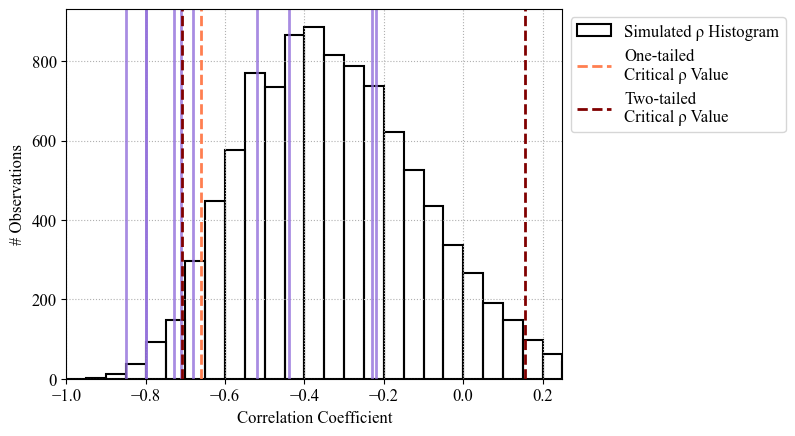

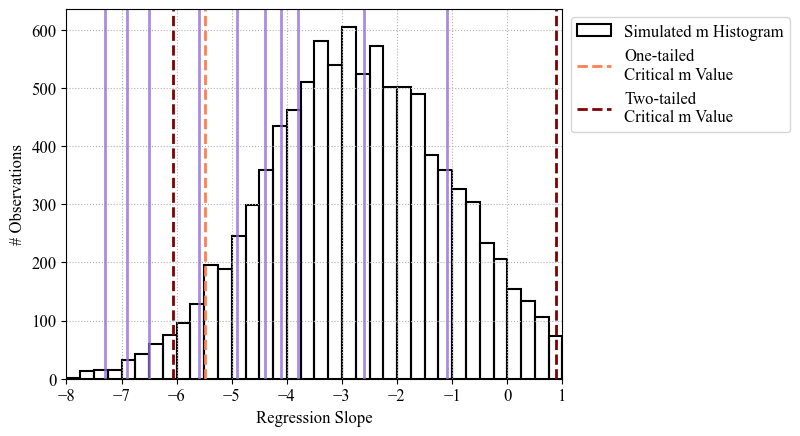

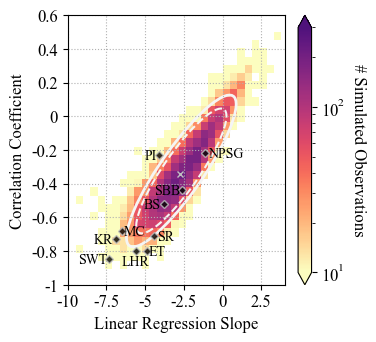

In [17]:
"""
Plot histogram of spearman's rho from simulations
with observed rho values from paleo datasets
"""
fig,ax=plt.subplots()
bin_edges=np.arange(-1,1,0.05)
ax.grid(linestyle=':',zorder=-20)
ax.hist(rho_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated ρ Histogram')
for i in dataframe['rho']:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_rho_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Correlation Coefficient')
plt.ylabel('# Observations')
ax.set_xlim(-1,.25)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

"""
Plot histogram of regression slopes from simulations
with observed slope values from paleo datasets
"""
fig,ax=plt.subplots()
bin_edges=np.arange(-8,2,0.25)
ax.grid(linestyle=':',zorder=-20)
ax.hist(slope_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated m Histogram')
for i in dataframe['slope']:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_slope_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Regression Slope')
plt.ylabel('# Observations')
ax.set_xlim(-8,1)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

"""
Plot 2d histogram of regression slopes and rho values
from simulations with observed values from paleo datasets
"""
# select colormap
cmap_orig = matplotlib.colormaps['magma_r']
cmap = ListedColormap(cmap_orig(np.linspace(0, 0.75, 200)))

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,half_width))

# plot 2d histogram of simulated slope and rho values
counts,ybins,xbins,im=ax.hist2d(slope_sims, rho_sims, bins=30, density=False,
                                norm=colors.LogNorm(vmin=10,vmax=300), 
                                cmin=2,cmap=cmap,zorder=1)

#add x denoting median simulation values
ax.plot(median_slope,median_rho,marker='x',
        color='silver',markersize=4,linestyle='None')

#add colorbar
cb=plt.colorbar(im,extend='both')
cb.set_label('# Simulated Observations', 
             rotation=270,labelpad=15,fontsize=12)

# plot rho and slope values from real coral and sediment datasets
for i in np.arange(0,len(dataframe.index),1):
    if i == 0:
        ax.plot(dataframe['slope'][i],dataframe['rho'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None',
                label='Observations')
    else:
        ax.plot(dataframe['slope'][i],dataframe['rho'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None')
    #add labels with each dataset abbreviation
    if dataframe['Abbreviation'][i] in ['SR','MC','NPSG','ET']:
        ax.text(dataframe['slope'][i]+.15,dataframe['rho'][i], 
                dataframe['Abbreviation'][i], ha='left',
                va='center',fontsize=10,rotation=0,color='k')
    elif dataframe['Abbreviation'][i] in ['LHR']:
        ax.text(dataframe['slope'][i],dataframe['rho'][i]-.02, 
                dataframe['Abbreviation'][i], ha='center',
                va='top',fontsize=10,rotation=0,color='k')
    else:
        ax.text(dataframe['slope'][i]-.15,dataframe['rho'][i], 
                dataframe['Abbreviation'][i], ha='right',
                va='center',fontsize=10,rotation=0,color='k')  

# add 90% and 95% confidence ellipses
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=1.645,
                   edgecolor='whitesmoke',linestyle='--',lw=1.5,label='90% CI')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=2.0,
                   edgecolor='whitesmoke',linestyle='-',lw=2,label='95% CI')

# set axis labels
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',fontsize=12)

#set axis limits
ax.set_ylim(-1,.6)
ax.set_xlim(-10,4)

# misc axis formatting
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.5))

#add gridlines
ax.grid(linestyle=':',zorder=10)

#add legend
#plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=10)

#save figure, display and close
plt.savefig('Figures/Supplementary_worstcasesim.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Generically exploring correlations in non-independent variables

C:\Users\gmpug\AppData\Local\Temp\ipykernel_18240\1921722273.py:10: RuntimeWarning: invalid value encountered in power
  exp=X**Y


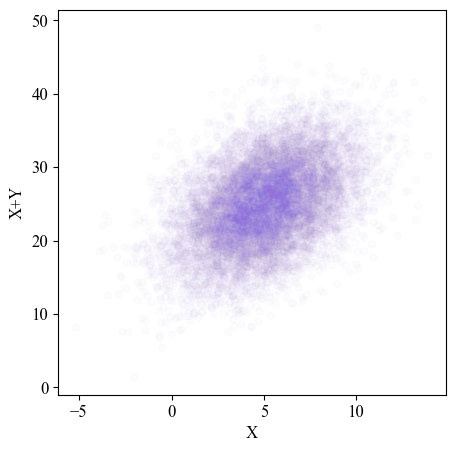

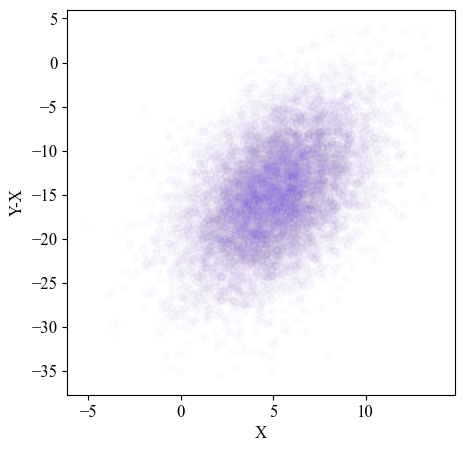

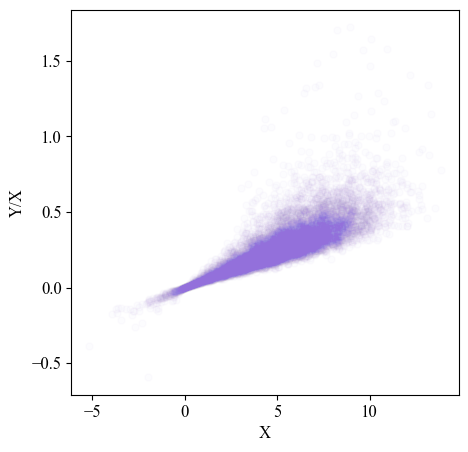

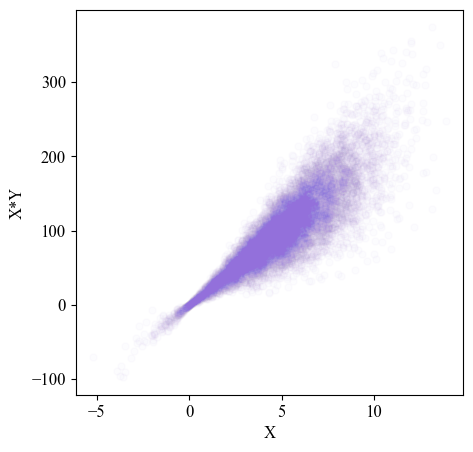

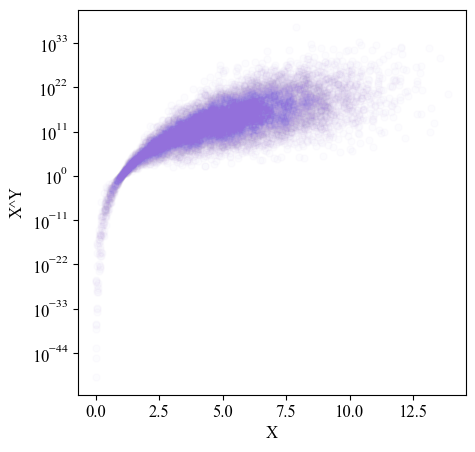

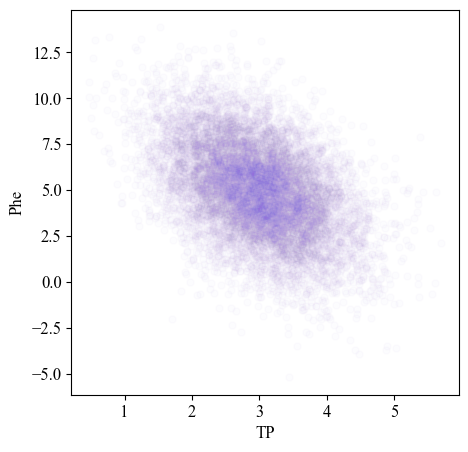

In [18]:
#demonstrating with more generic data
# X = np.random.uniform(0,10,1000)
# Y = np.random.uniform(15,30,1000)
X = np.random.normal(5,2.5,10000)
Y = np.random.normal(20,5,10000)
add=X+Y
sub=X-Y
div=X/Y
mult=X*Y
exp=X**Y
TP_calc=((Y-X)/7.6)+1

a=.02
c='mediumpurple'

#addition
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,add,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X+Y')
plt.show()
plt.close()

#subtraction
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,sub,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('Y-X')
plt.show()
plt.close()

#division
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,div,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('Y/X')
plt.show()
plt.close()

#multiplication
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,mult,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X*Y')
plt.show()
plt.close()

#exponent
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,exp,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X^Y')
ax.set_yscale('log')
plt.show()
plt.close()

#TP
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(TP_calc,X,marker='o',color=c,alpha=a,markersize=5,linestyle='None')
ax.set_xlabel('TP')
ax.set_ylabel('Phe')
plt.show()
plt.close()

# -----------------------------------------------------------------------------------------
# Mass Balance Ecosystem d15N Modeling
#### Can an ecosystem mass-balance model predict and help us explain mechanisms underlying observed coupling of TP and d15N Phe in paleoarchives?

### Define the mass-balance model

In [124]:
### Define the mass-balance model
"""
Define mass-balance model that predicts d15N Phe in PON as a function of
various parameters and the trophic structure of the planktic food web 
(relative abundance of phytoplankton and two trophic levels of zooplankton)
"""
def trophic_model(TP=2.5,            # desired trophic position
                  eps_assim1=4.0,    # d15N fractionation during phyto NO3 uptake
                  eps_assim2=8,      # d15N fractionation during phyto NH4 uptake
                  eps_exc=9,        # d15N fractionation during zooplankton NH4 excretion
                  p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4)
                  d_sNO3=5,          # d15N of source NO3 supplied to euphotic zone
                  f_rNO3=0,       # fraction of NO3 that goes unutilized by phytoplankton
                  p_NH4=1.0,         # NH4 utilization proportion
                  bulkphe_diff=-1.8, # d15N bulk minus d15N Phe in phytoplankton
                  TEF_Phe=0.58,         # d15N trophic enrichment of Phe per trophic transfer 
                  NO3_model='open',      # options are 'open' or 'rayleigh'
                  NH4_model='rayleigh',  # options are 'open' or 'rayleigh'
                  simple_output=True):   # True outputs only few variables, False many
    """
    First we find the fraction of the total nitrogen pool (derived from source NO3) that 
    partitions into:
    residual NH4 (f_rNH4), 
    grazing zooplankton (f_zoo1), 
    predator zooplankton (f_zoo2),
    phytoplankton (f_phy)
    The fraction in residual NO3 (f_rNO3) is given as a parameter. 
    """
    # calculate parameter pzoo1 
    p_zoo1=-0.5*TP+1.5

    #fraction calculations
    m=(f_rNO3-1)*(TP-1)*(p_exc-1)
    n=p_exc*(TP*p_NH4-TP-p_zoo1-p_NH4+3)+p_zoo1-2
    f_zoo1=(-p_zoo1*m)/n
    f_zoo2=((p_zoo1-1)*m)/n
    # f_zoo1=-((p_zoo1*(p_exc-1)+
    #           TP*p_zoo1*(1-p_exc)+
    #           f_rNO3*(TP*p_zoo1*(p_exc-1)+p_zoo1*(1-p_exc)))/
    #          (TP*p_exc*(p_NH4-1)+p_exc*(3-p_NH4)+p_zoo1*(1-p_exc)-2))
    #  f_zoo2=(f_zoo1*(1-p_zoo1))/p_zoo1
    f_rNH4=((f_zoo1+f_zoo2)*p_exc*(1-p_NH4))/(1-p_exc)    
    f_phy=1-f_rNO3-f_rNH4-f_zoo1-f_zoo2
    # the fraction of residual nitrate f_rNO3 is given in parameters, 
    # this just gives it same shape as other fraction variables
    f_rNO3=(f_phy*0)+f_rNO3

    # some checks to make sure everything is working right
    # check_fractions should sum to 1 
    # and PON_TP should match the input TP
    PON_TP=(1*f_phy+2*f_zoo1+3*f_zoo2)/(f_zoo1+f_zoo2+f_phy)
    check_fractions=f_rNO3+f_rNH4+f_phy+f_zoo1+f_zoo2

    """
    Then we calculate d15N of each of the 5 nitrogen pools:
    residual NO3 (d_rNO3), 
    residual NH4 (d_rNH4), 
    grazing zooplankton (d_zoo1), 
    predator zooplankton (d_zoo2),
    phytoplankton (d_phy)
    """
    if NO3_model in ['open']:
        d_rNO3=d_sNO3+(eps_assim1*(1-f_rNO3))
    elif NO3_model in ['rayleigh']:
        d_rNO3=d_sNO3-(eps_assim1*(np.log(f_rNO3)))
        
    if NH4_model in ['open']:
        d_phy=(-(f_zoo2*(f_rNH4*(eps_assim2*p_NH4+eps_exc*(2*p_exc-1))+3*f_zoo1*eps_exc*p_exc+d_rNO3*f_rNO3-d_sNO3)+
                f_zoo1*(f_rNH4*(eps_assim2*p_NH4+eps_exc*(p_exc-1))+d_rNO3*f_rNO3-d_sNO3)+2*(f_zoo2**2)*eps_exc*p_exc+(f_zoo1**2)*eps_exc*p_exc)/
              ((f_zoo2**2)+f_zoo2*(2*f_zoo1+f_phy+f_rNH4)+(f_zoo1**2)+f_zoo1*(f_phy+f_rNH4)))
    elif NH4_model in ['rayleigh']:
        d_phy=(-(f_zoo2*(f_rNH4*(eps_exc*(2*p_exc-1)-eps_assim2*np.log(1-p_NH4))+3*f_zoo1*eps_exc*p_exc+d_rNO3*f_rNO3-d_sNO3)+
                f_zoo1*(f_rNH4*(eps_exc*(p_exc-1)-eps_assim2*np.log(1-p_NH4))+d_rNO3*f_rNO3-d_sNO3)+2*(f_zoo2**2)*eps_exc*p_exc+(f_zoo1**2)*eps_exc*p_exc)/
              ((f_zoo2**2)+f_zoo2*(2*f_zoo1+f_phy+f_rNH4)+(f_zoo1**2)+f_zoo1*(f_phy+f_rNH4)))
    # if NH4_model in ['open']:
    #     x=-(h*(d*(kn+j*(2*m-1))+3*g*j*m+b*c-a)+g*(d*(k*n+j*(m-1))+b*c-a)+2*(h**2)*j*m+(g**2)*j*m)/((h**2)+h*(2*g+e+d)+(g**2)+g*(e+d))
    # elif NH4_model in ['rayleigh']:
    #     x=-(h*(d*(j*(2*m-1)-k*l)+3*g*j*m+b*c-a)+g*(d*(j*(m-1)-k*l)+b*c-a)+2*(h**2)*j*m+(g**2)*j*m)/((h**2)+h*(2*g+e+d)+(g**2)+g*(e+d))
    # d_phy=-(((-d_sNO3*(f_zoo1+f_zoo2))+
    #          (d_rNO3*f_rNO3*(f_zoo1+f_zoo2))+
    #          (f_rNH4*f_zoo1*eps_assim2*p_NH4)+
    #          (f_rNH4*f_zoo1*eps_exc*p_exc)-
    #          (f_rNH4*f_zoo1*eps_exc)+
    #          (f_rNH4*f_zoo2*eps_assim2*p_NH4)+
    #          (2*f_rNH4*f_zoo2*eps_exc*p_exc)-
    #          (f_rNH4*f_zoo2*eps_exc)+
    #          ((f_zoo1**2)*eps_exc*p_exc)+
    #          (3*f_zoo1*f_zoo2*eps_exc*p_exc)+
    #          (2*(f_zoo2**2)*eps_exc*p_exc))/
    #         ((f_zoo1+f_zoo2)*(f_rNH4+f_phy+f_zoo1+f_zoo2)))
    d_zoo1=d_phy+(p_exc*eps_exc)
    d_zoo2=d_zoo1+(p_exc*eps_exc)
    if NH4_model in ['open']:
        d_rNH4=(((d_zoo1-eps_exc)*(f_zoo1/(f_zoo1+f_zoo2)))+
               ((d_zoo2-eps_exc)*(f_zoo2/(f_zoo1+f_zoo2)))+
               (eps_assim2*p_NH4))
    elif NH4_model in ['rayleigh']:
        d_rNH4=(((d_zoo1-eps_exc)*(f_zoo1/(f_zoo1+f_zoo2)))+
               ((d_zoo2-eps_exc)*(f_zoo2/(f_zoo1+f_zoo2)))-
               (eps_assim2*(np.log(1-p_NH4))))
    """
    Finally we can estimate bulk d15N and d15N of Phe 
    based on the relative abundance and d15N values 
    of phytoplankton, grazers and predatory zooplankton 
    """
    sum_part=f_zoo1+f_zoo2+f_phy
    d_PON=(d_phy*(f_phy/sum_part))+(d_zoo1*(f_zoo1/sum_part))+(d_zoo2*(f_zoo2/sum_part))
    d_phe=(d_phy-bulkphe_diff)+(TEF_Phe*(PON_TP-1))
    
    # more diagnostic checks we can use to see if working correctly
    # check_d_sNO3 should equal the d_sNO3 imput parameter
    # PON_TP_iso should equal the input TP and PON_TP 
    check_d_sNO3=(f_rNO3*d_rNO3)+(f_rNH4*d_rNH4)+(f_phy*d_phy)+(f_zoo1*d_zoo1)+(f_zoo2*d_zoo2)
    PON_TP_iso=1+((d_PON-d_phy)/(p_exc*eps_exc))

    if simple_output==True:
        return(d_PON,
               d_phy,
               d_phe,
               PON_TP)
    else:
        return([d_rNO3,
               d_rNH4,
               d_phy,
               d_zoo1,
               d_zoo2,
               d_PON,
               d_phe,
               f_zoo1,
               f_zoo2,
               f_rNH4,
               f_phy,
               f_rNO3,
               PON_TP,
               PON_TP_iso,
               sum_part,
               check_d_sNO3,
               check_fractions])

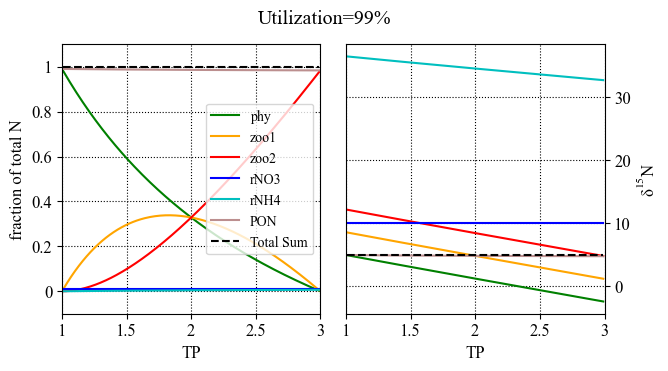

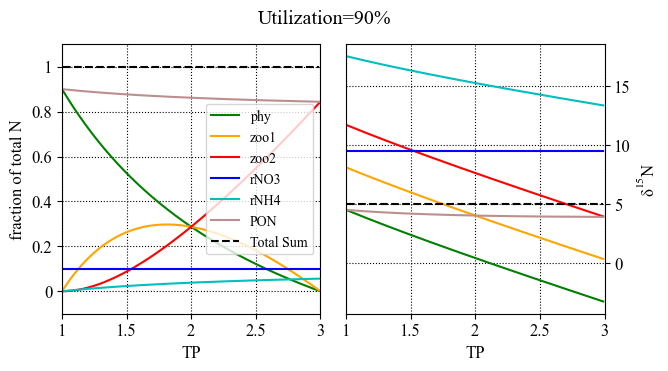

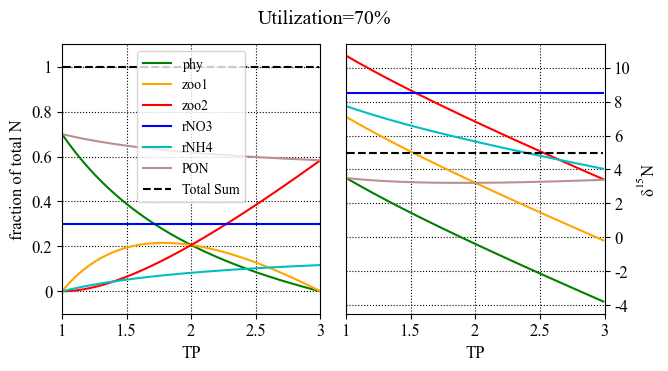

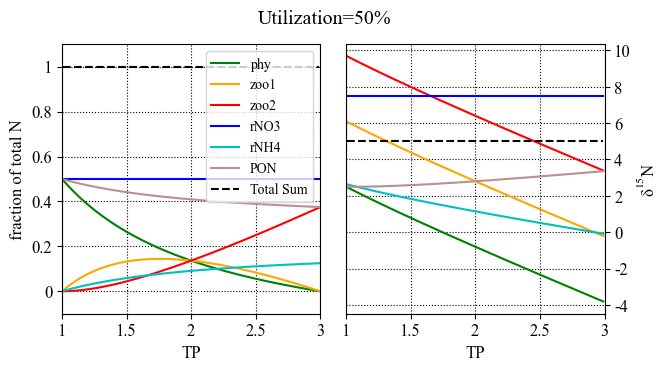

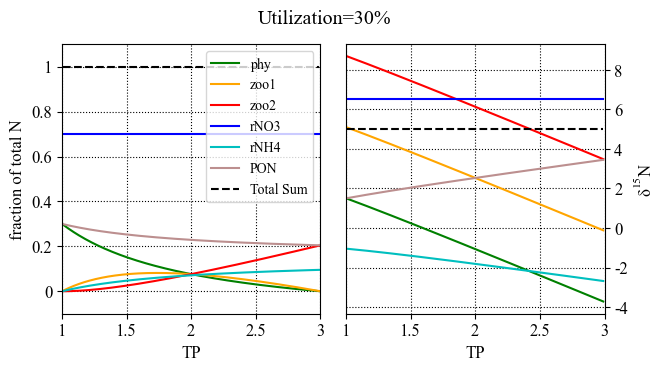

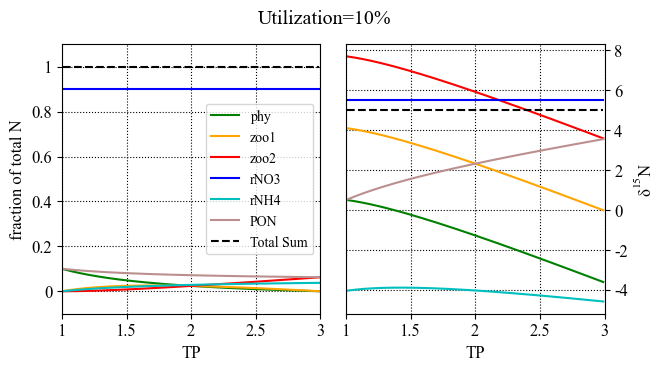

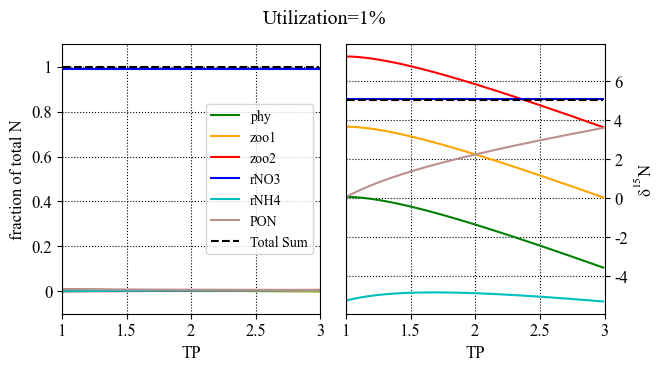

In [126]:
# plot TP vs fraction of each model component
TP=np.arange(1.01,3,.01)

for i in [.01,.1,.3,.5,.7,.9,.99]:
    list_outputs=trophic_model(TP=TP,            # desired trophic position
                               eps_assim1=5.0,    # d15N fractionation during phyto NO3 uptake
                               eps_assim2=8,      # d15N fractionation during phyto NH4 uptake
                               eps_exc=9,        # d15N fractionation during zooplankton NH4 excretion
                               p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4)
                               d_sNO3=5,          # d15N of source NO3 supplied to euphotic zone
                               f_rNO3=i,          # fraction of NO3 that goes unutilized by phytoplankton
                               p_NH4=1-i,         # NH4 utilization proportion
                               bulkphe_diff=-1.8, # d15N bulk minus d15N Phe in phytoplankton
                               TEF_Phe=0.58,         # d15N trophic enrichment of Phe per trophic transfer 
                               NO3_model='open',   # options are 'open' or 'rayleigh', specifies what model
                                                  # to use for NO3 utilization
                               NH4_model='rayleigh',
                               simple_output=False)
    d_rNO3,d_rNH4,d_phy,d_zoo1,d_zoo2,d_PON,d_phe,f_zoo1,f_zoo2,f_rNH4,f_phy,f_rNO3,PON_TP,PON_TP_iso,sum_part,check_d_sNO3,check_fractions=list_outputs
    
    fig,axs=plt.subplots(1,2,figsize=(full_width,half_width))
    plt.subplots_adjust(wspace=.1)
    
    axs[0].plot(TP,f_phy,color='g',label='phy')
    axs[0].plot(TP,f_zoo1,color='orange',label='zoo1')
    axs[0].plot(TP,f_zoo2,color='r',label='zoo2')
    axs[0].plot(TP,f_rNO3,color='b',label='rNO3')
    axs[0].plot(TP,f_rNH4,color='c',linestyle='-',label='rNH4')
    axs[0].plot(TP,sum_part,color='rosybrown',linestyle='-',label='PON')
    axs[0].plot(TP,check_fractions,color='k',linestyle='--',label='Total Sum')

    axs[1].plot(TP,d_phy,color='g')
    axs[1].plot(TP,d_zoo1,color='orange')
    axs[1].plot(TP,d_zoo2,color='r')
    axs[1].plot(TP,d_rNO3,color='b')
    axs[1].plot(TP,d_rNH4,color='c',linestyle='-')
    axs[1].plot(TP,d_PON,color='rosybrown',linestyle='-')
    axs[1].plot(TP,check_d_sNO3,color='k',linestyle='--')

    for ax in [axs[0],axs[1]]:
        ax.grid(linestyle=':',color='k')
        ax.set_xlabel('TP')
        ax.set_xlim(1,3)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    axs[0].set_ylabel('fraction of total N')
    axs[1].set_ylabel('$\mathdefault{δ^{15}N}$')

    axs[0].set_ylim(-.1,1.1)
    #axs[1].set_ylim(-6,20)

    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    
    axs[0].legend(fontsize=10)
    
    plt.suptitle('Utilization='+str(round((1-i)*100))+'%')
    plt.show()
    plt.close()

0.999 0.0010000000000000009
0.9 0.09999999999999998
0.8 0.19999999999999996
0.7 0.30000000000000004
0.6 0.4
0.5 0.5
0.4 0.6
0.3 0.7
0.2 0.8
0.1 0.9


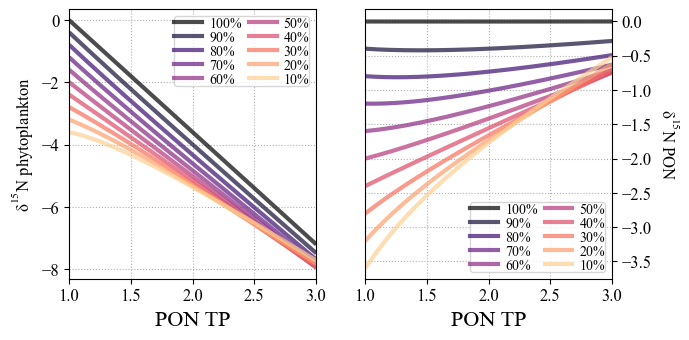

In [129]:
#plot modeled d15N_phe and d15N_PON sensitivity to f_rNH4

TP=np.arange(1.01,3,.01)
p_NH4_array=np.flip(np.array([.10,.20,.30,.40,.50,.60,.70,.80,.90,.999]))
colors=matplotlib.colormaps['magma'](np.linspace(0, .9, len(p_NH4_array)))

fig,axs=plt.subplots(1,2,figsize=(full_width,half_width))

for i in np.arange(0,len(p_NH4_array),1):
    p_NH4=p_NH4_array[i]
    f_rNO3=1-p_NH4
    d_PON,d_phy,d_phe,PON_TP=trophic_model(TP=TP,p_NH4=p_NH4,f_rNO3=f_rNO3,d_sNO3=0,NH4_model='open')
    axs[0].plot(PON_TP,d_phy,color=colors[i],label=str(round(p_NH4*100))+'%',linewidth=3,alpha=.7)
    axs[1].plot(PON_TP,d_PON,color=colors[i],label=str(round(p_NH4*100))+'%',linewidth=3,alpha=.7)
    print(p_NH4,f_rNO3)
    
for ax in [0,1]:   
    axs[ax].set_xlim(1,3)
    axs[ax].set_xlabel('PON TP',fontsize=16)
    axs[ax].tick_params(axis='both', which='major')
    axs[ax].grid(axis='both', linestyle=':')
    axs[ax].legend(facecolor='w',fontsize=10,ncol=2,
                   columnspacing=.5,borderpad=0,
                   labelspacing=0,handletextpad=.5)

axs[0].set_ylabel('$\mathregular{δ^{15}N}$ phytoplankton')
axs[1].set_ylabel('$\mathregular{δ^{15}N}$ PON',rotation=270,labelpad=20)

# move y axis ticks and axis label to right
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

# plt.title('% utilization (assuming constant d15N sNO3='+str(d_sNO3)
#            +'‰,\nɛ_assim='+str(eps_assim1)+'‰, ɛ_exc='+str(eps_exc)+'‰,p_exc='+str(p_exc),
#            fontsize=12,ha='center')
#plt.savefig(r'C:\Users\EVE\Dropbox\Eve\NE Pacific corals\NE Pacific corals\sur ridge manuscript figs\model_sensitivity_Nh4ut_phyto.png', dpi=400,bbox_inches='tight')

plt.show()
plt.close()

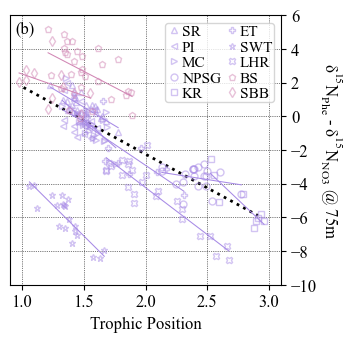

In [39]:
# Get predicted d15N Phe values from mass-balance model and plot with observations
TP=np.arange(1.01,2.99,.1)
d_PON,d_phe,PON_TP=trophic_model(TP=TP)

# set markers to used for each study site
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']

# set colors to use
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

#plot mass balance model results
plt.plot(TP,d_phe,linestyle=':',color='k',lw=2)

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor #select color
        
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1 
    else:
        mec_sel=sedcolor #select color
        
        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
        
    # subtract d15N NO3 at given site and selected depth from 
    # Rafter et al., 2019 climatology
    Phe_calc=Phe_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    
    # plot TP vs Phe points
    plt.plot(TP_sel,
             Phe_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Phe_calc)[0]
    b=scipy.stats.linregress(TP_sel,Phe_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,linestyle='-',alpha=1,
             lw=.75,color=mec_sel)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
             rotation=270,labelpad=20)

#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-10,6)

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add legend
ax.legend(fontsize=11,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig2b_altwmodel.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2b_altwmodel.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

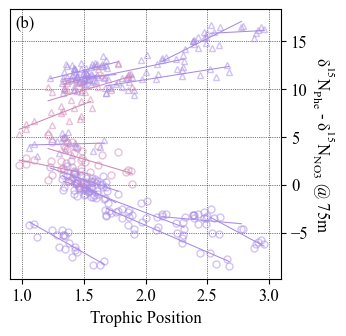

In [177]:
# set markers to used for each study site
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']

# set colors to use
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor #select color
        
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1 
    else:
        mec_sel=sedcolor #select color
        
        # no TP correction needed for sediment datasets
        TP_sel=TP_obs_list[i]
        
    # subtract d15N NO3 at given site and selected depth from 
    # Rafter et al., 2019 climatology
    Phe_calc=Phe_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    Glu_calc=Glu_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    
    # plot TP vs Phe points
    ax.plot(TP_sel,
             Phe_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker='o',
             label=dataframe['Abbreviation'].iloc[i])

    # plot TP vs Glu points
    #ax2=ax.twinx()
    ax.plot(TP_sel,
             Glu_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker='^',
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Phe_calc)[0]
    b=scipy.stats.linregress(TP_sel,Phe_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,linestyle='-',alpha=1,
             lw=.75,color=mec_sel)

    # calculate slope and intercept for the TP-Glu
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Glu_calc)[0]
    b=scipy.stats.linregress(TP_sel,Glu_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,linestyle='-',alpha=1,
             lw=.75,color=mec_sel)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
             rotation=270,labelpad=20)
# ax2.set_ylabel('$\mathdefault{δ^{15}N_{Glu}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
#              rotation=270,labelpad=20)
#set axis limits
ax.set_xlim(0.9,3.1)
# ax.set_ylim(-10,6)

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
# plt.savefig('Figures/Fig2b_altwmodel.png',bbox_inches='tight', dpi=1000)
# plt.savefig('Figures/Fig2b_altwmodel.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()